<a href="https://colab.research.google.com/github/peeyushsinghal/da/blob/main/mitigating_bias_sa_da_v25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mitigating bias in sentiment analysis using domain adaptation

In [1]:
! pip install torchtext==0.10.0 --quiet # DOWNGRADE YOUR TORCHTEXT
! pip install ekphrasis --quiet # library to pre process twitter data
! pip install emoji --upgrade --quiet #library to deal with emoji data

In [2]:
## Import statements
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.legacy.data import Dataset, Field, TabularDataset, BucketIterator
from torchtext.vocab import GloVe
import torchtext.vocab as vocab
import numpy as np
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import emoji
from torchtext.legacy.vocab import Vectors
from tqdm import tqdm
import random
import torch.optim as optim
import scipy.stats as stats
from statistics import mean

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

import time

from copy import deepcopy

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# checking device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:{}".format(DEVICE))

Running on:cuda


## Data loading

In [4]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Configuration

In [5]:

BASE_PATH = '/content/drive/MyDrive/semeval-2018'

DATA_DIR = os.path.join(BASE_PATH,'datasets')
TARGET_DIR = os.path.join(BASE_PATH,'targetdataset')

MODEL_DIR = os.path.join(BASE_PATH,'models')
REF_DIR = os.path.join(BASE_PATH,'reference')
EMBEDDINGS_DIR = os.path.join(BASE_PATH,'embeddings')

MAX_SIZE = 50
MAX_VOCAB_SIZE = 10000
BATCH_SIZE = 8


 
EMBEDDING_TO_BE_USED = 'glove_gn' # {'glove', 'glove_gn'}
TARGET_BATCH_SIZE = 8

NUM_EPOCHS = 100
# NUM_EPOCHS = 2

EWC_LAMBDA = 0.4

if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
  print("The new directory is created!")

# EMB_MATRIX_DIR = os.path.join(BASE_PATH,'emb_matrix')
# if not os.path.exists(EMB_MATRIX_DIR):
#   os.makedirs(EMB_MATRIX_DIR)
#   print("The Embedding Matrix directory is created!")


BONFERRONI_CORRECTION = 5.0

In [6]:
# data configuration

class TASK1(object):
  
    EI_reg = {
        'anger': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-anger-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-anger-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-anger-test-gold.txt')
                },
        'joy': {
                'train': os.path.join(
                    DATA_DIR, 'task1/EI-reg/training/EI-reg-En-joy-train.txt'),
                'dev': os.path.join(
                    DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-joy-dev.txt'),
                'gold': os.path.join(
                    DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-joy-test-gold.txt')
                },
        'fear': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-fear-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-fear-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-fear-test-gold.txt')
                },
        'sadness': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-sadness-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-sadness-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-sadness-test-gold.txt')
                }                     
        }

    V_reg = {
        'train': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-train.txt'),
        'dev': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-dev.txt'),
        'gold': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-test-gold.txt')
             }

    EEC = {
        'eec': os.path.join(
            DATA_DIR, 'task1/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')
             }

## Source Data
Parsing Emotion and Valence regression data : `format [ID	Tweet	Affect Dimension	Intensity Score]`

In [7]:
def parse_reg(data_file, label_format='tuple'):
    """
    This is for datasets for the EI-reg and V-reg English tasks 
    Returns:
        df: dataframe with columns in the first row of file [ID-Tweet-Affect Dimension-Intensity Score]
    """
    with open(data_file, 'r') as fd:
      data = [l.strip().split('\t') for l in fd.readlines()]
    # print(data)
    df = pd.DataFrame (data[1:],columns=data[0])
    csv_file_name = (data_file.split("/")[-1]).split('.')[0]+".csv"
    csv_file = df.to_csv(str(csv_file_name))
    return csv_file_name


Generic Source Data Parser

In [8]:
def parse_csv(task, dataset, emotion='anger'):
    if task == 'EI-reg':
        data_train = TASK1.EI_reg[emotion][dataset]
        csv_file_name = parse_reg(data_train)
        return csv_file_name

    elif task == 'V-reg':
        data_train = TASK1.V_reg[dataset]

        csv_file_name = parse_reg(data_train)
        return csv_file_name

    else:
        return None

In [9]:
emotions = ['anger','joy','fear','sadness']
dict_data ={'train':'train','dev':'val','gold':'test'}
dict_file_name ={}
for emotion in emotions:
  for data_info, data_usage in dict_data.items():
    file_name = str('file_EI_'+ emotion + "_" + data_usage)
    dict_file_name[file_name] = parse_csv('EI-reg', data_info, emotion)

    file_name2 = str('file_V_'+ data_usage)
    dict_file_name[file_name2] = parse_csv('V-reg', data_info)

(dict_file_name)

{'file_EI_anger_train': 'EI-reg-En-anger-train.csv',
 'file_V_train': '2018-Valence-reg-En-train.csv',
 'file_EI_anger_val': '2018-EI-reg-En-anger-dev.csv',
 'file_V_val': '2018-Valence-reg-En-dev.csv',
 'file_EI_anger_test': '2018-EI-reg-En-anger-test-gold.csv',
 'file_V_test': '2018-Valence-reg-En-test-gold.csv',
 'file_EI_joy_train': 'EI-reg-En-joy-train.csv',
 'file_EI_joy_val': '2018-EI-reg-En-joy-dev.csv',
 'file_EI_joy_test': '2018-EI-reg-En-joy-test-gold.csv',
 'file_EI_fear_train': 'EI-reg-En-fear-train.csv',
 'file_EI_fear_val': '2018-EI-reg-En-fear-dev.csv',
 'file_EI_fear_test': '2018-EI-reg-En-fear-test-gold.csv',
 'file_EI_sadness_train': 'EI-reg-En-sadness-train.csv',
 'file_EI_sadness_val': '2018-EI-reg-En-sadness-dev.csv',
 'file_EI_sadness_test': '2018-EI-reg-En-sadness-test-gold.csv'}

## Preprocess tweets

In [10]:
# reference : https://github.com/cbaziotis/ekphrasis


text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [11]:
def preprocess_tweet(tweet): 
  tweet_processed = text_processor.pre_process_doc(tweet)
  # print (tweet_processed)
  demojized_list =[]
  final_list =[]
  for index, tweet in enumerate(tweet_processed):
      demojized_list.append(emoji.demojize(tweet, language = 'en'))
  final_list = [w for w in demojized_list if w not in en_stops] 
  
  # print(df)
  return final_list

## TorchText Treatment

In [12]:
dict_file_name.keys()

dict_keys(['file_EI_anger_train', 'file_V_train', 'file_EI_anger_val', 'file_V_val', 'file_EI_anger_test', 'file_V_test', 'file_EI_joy_train', 'file_EI_joy_val', 'file_EI_joy_test', 'file_EI_fear_train', 'file_EI_fear_val', 'file_EI_fear_test', 'file_EI_sadness_train', 'file_EI_sadness_val', 'file_EI_sadness_test'])

In [13]:
dict_fields ={}
list_name = list(set(["_".join(key.split("_")[1:-1]) for key in list(dict_file_name.keys())]))


for name in list_name:
  field_tweet = Field(sequential=True, 
                      use_vocab = True, 
                      tokenize = preprocess_tweet, 
                      fix_length = MAX_SIZE, 
                      batch_first = True)
  field_intensity = Field(sequential= False, 
                        dtype = torch.float,
                        use_vocab = False)
  fields = {
    'Tweet':('tweet', field_tweet ), #
    'Intensity Score': ('intensity',field_intensity) # Intensity Score is name of the dataset column, field_intensity is how we have defined the field, intensity is the name of the variable going fwd
    }
  
  dict_fields[name] = fields

  # dict_fields[name]= { 'field_tweet': Field(sequential=True,
  #                                        use_vocab = True,
  #                                        tokenize = preprocess_tweet,
  #                                        fix_length = MAX_SIZE,
  #                                        batch_first = True ), 
  #                           'field_intensity': Field(sequential= False,
  #                                              dtype = torch.float,
  #                                              use_vocab = False )}

dict_fields

{'EI_sadness': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f25804777f0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f25ef9c0790>)},
 'EI_joy': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f257ffda6a0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f257ffdac40>)},
 'EI_fear': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f257ffdab20>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f257ffdaeb0>)},
 'EI_anger': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f257ffda5b0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f257ffdaa90>)},
 'V': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f257ffda6d0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f257ffda2e0>)}}

In [14]:
dict_fields['EI_sadness']['Tweet'][1]

In [15]:
dict_dataset ={}
for file_key, file_name in dict_file_name.items():
  # print(file_key,file_name)
  if "train" in (file_key.split("_")[-1]):
    head_name = "_".join(file_key.split("_")[0:-1])
    base_name = "_".join(file_key.split("_")[1:-1])
    # print(base_name)
    train_file = dict_file_name[head_name+"_train"]
    val_file = dict_file_name[head_name+"_val"]
    test_file =  dict_file_name[head_name+"_test"]

    train, val, test =TabularDataset.splits( path = './', 
                                            train = train_file, 
                                            validation = val_file, 
                                            test = test_file,
                                            format = 'csv', 
                                            fields = dict_fields[base_name])
    
    # print(train_file,val_file,test_file)
    
    # dict_dataset[base_name+"_train"], dict_dataset[base_name+"_val"],dict_dataset[base_name+"_test"]=TabularDataset.splits( path = './',
    #                                                                                                                        train = train_file,
    #                                                                                                                        validation = val_file,
    #                                                                                                                        test = test_file,
    #                                                                                                                        format = 'csv',
    #                                                                                                                        fields = fields)
    dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}

In [16]:
dict_dataset

{'EI_anger': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254ea9bdc0>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254ea9bcd0>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254e4b8970>},
 'V': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254e883fd0>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254d917ac0>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254d3f7a00>},
 'EI_joy': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254cc11310>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254c638be0>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254c4de760>},
 'EI_fear': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254c410dc0>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f254c1d91c0>,
  'test_dataset': <torchtext.legacy

In [17]:
for key, value in dict_dataset.items():
  # count = 0
  for name, dataset in value.items():
    for example in dataset.examples:
      print(key, name, example.tweet, example.intensity)
      break


# for example in test_data.examples:
#   print(example.tweet, example.intensity)
#   count += 1
#   if count > 2:
#     break

EI_anger train_dataset ['<user>', '<user>', 'shut', 'hashtags', 'cool', '<hashtag>', 'offended', '</hashtag>'] 0.562
EI_anger val_dataset ["'", 'need', 'something', '.', 'something', 'must', 'done', '!', '<repeated>', "'", '\\', 'n', '\\', 'nyour', 'anxiety', 'amusing', '.', 'nothing', 'done', '.', 'despair', '.'] 0.517
EI_anger test_dataset ['<user>', 'know', 'mean', 'well', 'offended', '.', 'prick', '.'] 0.734
V train_dataset ['<user>', 'yeah', '!', '<happy>', 'playing', 'well'] 0.600
V val_dataset ['<user>', 'site', 'crashes', 'everytime', 'try', 'book', '-', 'help', '?', 'tell', "'", 'nothing', 'wrong', '&', 'hang', '<hashtag>', 'furious', '</hashtag>', '<hashtag>', 'helpless', '</hashtag>', '<user>'] 0.141
V test_dataset ['gm', '<hashtag>', 'tuesday', '</hashtag>', '!'] 0.589
EI_joy train_dataset ['<user>', 'quite', 'saddened', '.', '<repeated>', 'us', 'dates', ',', 'joyous', 'anticipation', 'attending', 'dg', 'concert', '(', 'since', '<number>', ')', '.', 'happy', 'keeping', 'bus

## Building iterator and Vocabulary

In [18]:
for name, value in dict_fields.items():
  print(name, value)

EI_sadness {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f25804777f0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f25ef9c0790>)}
EI_joy {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f257ffda6a0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f257ffdac40>)}
EI_fear {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f257ffdab20>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f257ffdaeb0>)}
EI_anger {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f257ffda5b0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f257ffdaa90>)}
V {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f257ffda6d0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f257ffda2e0>)}


In [19]:
dict_emb_file = {'glove':'glove.6B.300d.txt',
                 'glove_gn': '1b-vectors300-0.8-0.8.txt'}

print("EMBEDDING_TO_BE_USED:", EMBEDDING_TO_BE_USED)
emb_file_path = os.path.join(EMBEDDINGS_DIR ,dict_emb_file[EMBEDDING_TO_BE_USED])
emb_file_path

EMBEDDING_TO_BE_USED: glove_gn


'/content/drive/MyDrive/semeval-2018/embeddings/1b-vectors300-0.8-0.8.txt'

In [20]:

for name, value in dict_fields.items():
  print(name, value['Tweet'][1])
  # value['Tweet'][1].build_vocab(dict_dataset[name]['train_dataset'],
  #                                  max_size = MAX_VOCAB_SIZE,
  #                                  min_freq = 1,
  #                                  vectors = "glove.6B.100d",
  #                                  unk_init=torch.Tensor.normal_)
  
  ## start for embeddings from text file
  value['Tweet'][1].build_vocab(dict_dataset[name]['train_dataset'])
  vectors = vocab.Vectors(emb_file_path) # location of embeddings file, full path
  value['Tweet'][1].vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)
  ## end for embeddings from text file

  value['Intensity Score'][1].build_vocab(dict_dataset[name]['train_dataset'])


EI_sadness <torchtext.legacy.data.field.Field object at 0x7f25804777f0>


100%|█████████▉| 142526/142527 [00:10<00:00, 13218.77it/s]


EI_joy <torchtext.legacy.data.field.Field object at 0x7f257ffda6a0>
EI_fear <torchtext.legacy.data.field.Field object at 0x7f257ffdab20>
EI_anger <torchtext.legacy.data.field.Field object at 0x7f257ffda5b0>
V <torchtext.legacy.data.field.Field object at 0x7f257ffda6d0>


In [21]:
dict_iterator ={}
for name, value in dict_dataset.items():
  VALID_BATCH_SIZE = len(value['val_dataset']) - 1
  TEST_BATCH_SIZE = len(value['test_dataset'])  -1
  # VALID_TEST_BATCH_SIZE= min(len(value['val_dataset']),len(value['test_dataset']) )
  print(name, VALID_BATCH_SIZE , TEST_BATCH_SIZE)
  train_iterator, val_iterator, test_iterator= BucketIterator.splits(
      (value['train_dataset'], value['val_dataset'],value['test_dataset']),
      batch_sizes= (BATCH_SIZE,VALID_BATCH_SIZE, TEST_BATCH_SIZE),
      sort_key = lambda x: len(x.tweet),
      sort_within_batch=True,
      device = DEVICE,
      shuffle= True)
  
  dict_iterator[name] = {"train_iterator": train_iterator, "val_iterator":val_iterator,"test_iterator":test_iterator}

  # dict_iterator[name]['train_iterator'], dict_iterator[name]['val_iterator'], dict_iterator[name]['test_iterator'] = BucketIterator.splits((dict_dataset[name]['train_dataset'], dict_dataset[name]['val_dataset'],dict_dataset[name]['test_dataset']), 
  #                                                     batch_sizes= (BATCH_SIZE,VALID_TEST_BATCH_SIZE,VALID_TEST_BATCH_SIZE),
  #                                                     sort_key = lambda x: len(x.tweet),
  #                                                     sort_within_batch=True,
  #                                                     device = DEVICE,
  #                                                     shuffle= True)

EI_anger 387 1001
V 448 936
EI_joy 289 1104
EI_fear 388 985
EI_sadness 396 974


In [22]:
dict_iterator.items()

dict_items([('EI_anger', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490ba040>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490ba100>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490ba190>}), ('V', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490ba460>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490ba550>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490ba5e0>}), ('EI_joy', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490ba850>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490ba910>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490ba9d0>}), ('EI_fear', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25490bac70>, 'val_iterator': <torchtex

In [23]:
for key, value in dict_iterator.items():
  for name, iterator in value.items():
    for batch in iterator:
      print(key, name, batch.tweet)
      print(batch.intensity)
      break
    break
  break
    
# count = 0a
# for batch in train_iterator:
#   print (batch.tweet)
#   print (batch.intensity)
#   count += 1
#   if count > 2:
#     break

EI_anger train_iterator tensor([[   5, 4321,  208, 1282,    6,  625,   11,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [1135,  260, 2511, 3095,   44,  101,  256,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   5, 1287,    4,   91, 3585,    4,    9,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,   

In [24]:
for name in list_name:
  print(dict_fields[name]['Tweet'][1].vocab.stoi.items())

dict_items([('<unk>', 0), ('<pad>', 1), ('</hashtag>', 2), ('<hashtag>', 3), ('.', 4), ('<user>', 5), (',', 6), ("'", 7), ('<repeated>', 8), ('!', 9), ('\\', 10), ('-', 11), ('<number>', 12), ('?', 13), ('</allcaps>', 14), ('<allcaps>', 15), ('n', 16), ('sad', 17), ('get', 18), ('&', 19), ('lost', 20), ('like', 21), ('depression', 22), ('blues', 23), ('sadness', 24), (':sparkles:', 25), ('sober', 26), ('serious', 27), ('one', 28), ('know', 29), ('day', 30), ('time', 31), ('dark', 32), (':', 33), ('unhappy', 34), ('depressing', 35), ('life', 36), ('good', 37), ('people', 38), ('feel', 39), ('love', 40), ('see', 41), ('u', 42), ('go', 43), ('would', 44), (':face_with_tears_of_joy:', 45), ('grim', 46), ('think', 47), ('really', 48), ('got', 49), ('despair', 50), ('still', 51), ('want', 52), ('let', 53), ('need', 54), ('someone', 55), ('today', 56), ('always', 57), ('dull', 58), ('even', 59), ('going', 60), ('never', 61), ('new', 62), ('sink', 63), ('/', 64), ('dreadful', 65), ('gloomy', 6

## TorchText treatment of Target Data

In [25]:
# Target Data
df_target = pd.read_csv(os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'))
print(df_target.head())
target_file_name = 'target_csv.csv'
target_csv_file = df_target.to_csv(str(target_file_name))

                             Tweet  Intensity Score
0    the actor finished her work .                0
1    the actor finished his work .                0
2  the actuary finished her work .                0
3  the actuary finished his work .                0
4    the agent finished her work .                0


In [26]:
dict_target_dataset = {}
for name in list_name:
  # print(dict_fields[name])
  dict_target_dataset [name] = TabularDataset( path = os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'), 
                                              format = 'csv',
                                              fields = dict_fields[name] )

print(dict_target_dataset)

{'EI_sadness': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f257ffda9d0>, 'EI_joy': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f25ef9a7ac0>, 'EI_fear': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f25804ea940>, 'EI_anger': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f254a2f5b20>, 'V': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f254a9dae20>}


In [27]:
for name, dataset in dict_target_dataset.items():
  count=0
  for example in dataset:
    print(example.tweet, example.intensity)
    count += 1
    if count > 2:
      break

['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0


In [28]:
dict_target_iterator = {}
for name in list_name:
  dict_target_iterator [name] = BucketIterator(dict_target_dataset[name], # given that there is only one dataset we are not using splits
                                 batch_size= TARGET_BATCH_SIZE,
                                 sort_key = lambda x: len(x.tweet),
                                 sort_within_batch=True,
                                 device = DEVICE,
                                 repeat=True,
                                 shuffle= True)

print(dict_target_iterator)

{'EI_sadness': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f2548492190>, 'EI_joy': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f2548492160>, 'EI_fear': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f2548492220>, 'EI_anger': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f2548492340>, 'V': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f25484923d0>}


In [29]:
# next(iter(target_iterator))

In [30]:
for name, iterator in dict_target_iterator.items():
  count = 0
  for batch in iterator:
    print(name)
    print(batch)
    print (batch.tweet)
    print (batch.intensity)
    count += 1
    break
    if count > 2:
      break

EI_sadness

[torchtext.legacy.data.batch.Batch of size 8]
	[.tweet]:[torch.cuda.LongTensor of size 8x50 (GPU 0)]
	[.intensity]:[torch.cuda.FloatTensor of size 8 (GPU 0)]
tensor([[   0, 1651,    0,    0,    0,    4,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   0,  614, 3104, 4280,    0,    4,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   0,  288,    0,    0,    0,    4,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1, 

In [31]:
# count = 0
# for batch in target_iterator:
#   print(batch)
#   print (batch.tweet)
#   print (batch.intensity)
#   count += 1
#   if count > 2:
#     break

## CNN 1d model

### Gradient Reversal layer

In [32]:
from torch.autograd import Function


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

CNN 1 D model
Reference: A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification, Ye Zhang, Byron Wallace 2015

Difference:

use of embedding
use of sigmoid function, as we are having a regression model not a classififer as the main task

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1d(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout, 
                 pad_idx
                 ):
        super().__init__()
        
        #---------------------Feature Extractor Network----------------------#
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # Convolutional Network
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        #---------------------Regression Network------------------------#
        # Fully-connected layer and Dropout
        self.regression = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, output_dim)
            # ,
            # nn.Sigmoid()
        )
        # self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim * 10)
        # self.fc2 = nn.Linear(output_dim * 10, output_dim)
        # self.dropout = nn.Dropout(dropout)

        #---------------------Domain Classifier Network------------------------#
        # Fully-connected layer and Dropout
        self.domain_classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, 2),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, text, alpha=1.0):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        x_feature = torch.cat(pooled, dim = 1)
        
        #x_feature = [batch size, n_filters * len(filter_sizes)]
        
        reverse_feature = GradientReversalFn.apply(x_feature, alpha)
        # print("reverse_feature",reverse_feature)
    
        regression_output = self.regression(x_feature)
    
        domain_classifier_output = self.domain_classifier(reverse_feature)


        return regression_output, domain_classifier_output

In [34]:
# INPUT_DIM = len(field_tweet.vocab) # these change for each model
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5
# PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # these change for each model

### Model Architecture Creation for each variant, Loading pre-trained embeddings

In [35]:
dict_model_arch ={}
for name in list_name:
  
  # INPUT_DIM = len(field_tweet.vocab) # single model
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  # print(INPUT_DIM)

  # PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # # single model
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]
  # print(PAD_IDX)

  dict_model_arch[name] = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  dict_model_arch[name].to(DEVICE)

  # pretrained_embeddings = field_tweet.vocab.vectors # single model
  pretrained_embeddings = dict_fields[name]['Tweet'][1].vocab.vectors

  # model.embedding.weight.data.copy_(pretrained_embeddings) # single model
  # dict_model_arch[name].embedding.weight.data.copy_(pretrained_embeddings)

  ## start for embeddings from text file
  dict_model_arch[name].embedding.from_pretrained(torch.FloatTensor(dict_fields[name]['Tweet'][1].vocab.vectors))
  ## end for embeddings from text file

  # UNK_IDX = field_tweet.vocab.stoi[field_tweet.unk_token] # single model
  UNK_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].unk_token]

  # model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) 
  
  # model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) 

dict_model_arch

{'EI_sadness': CNN1d(
   (embedding): Embedding(4859, 100, padding_idx=1)
   (convs): ModuleList(
     (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
     (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
     (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
     (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
   )
   (regression): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=1, bias=True)
   )
   (domain_classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=2, bias=True)
     (6): LogSoftmax(dim=1)
   )
 ), 'EI_joy': CNN1d(
   (embedding): Embeddi

In [36]:
# model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# model.to(DEVICE)

### Load Pre trained embeddings
we'll load the pre-trained *embeddings*

In [37]:
# pretrained_embeddings = field_tweet.vocab.vectors
# model.embedding.weight.data.copy_(pretrained_embeddings)

In [38]:
# field_tweet.vocab.vectors.shape

In [39]:
# UNK_IDX = field_tweet.vocab.stoi[field_tweet.unk_token]

# model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
# model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Training the model

### Without training one forward pass

In [40]:
for name, model_arch in dict_model_arch.items():
  for batch in dict_iterator[name]['train_iterator']:
    print(batch.tweet)
    output = model_arch(batch.tweet)
    print (output)
    break

tensor([[   5,  266,   66,  468,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [  77, 2568,   20,    4,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [  61,   53,   41,   89,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,   

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [41]:
# import torch.optim as optim

# optimizer = optim.Adam(model.parameters())

# criterion = nn.BCEWithLogitsLoss()

# model = model.to(DEVICE)
# criterion = criterion.to(DEVICE)

### Typical Train Model Function

In [42]:
# Typical Training Function

from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader, optimizer, epoch):
    # model.train() # setting the model in training mode
    pbar = tqdm(train_loader) # putting the iterator in pbar
    correct = 0 # for accuracy numerator
    processed =0 # for accuracy denominator
    epoch_loss = 0.0
    
    # used for EWC
    # fisher_dict_m = {}
    # optpar_dict_m = {}

    for batch_idx, batch in enumerate(pbar):

        tweets, intensities = batch.tweet.to(device), batch.intensity.to(device)  # plural, we are not interested in domain
        #sending data to CPU or GPU as per device
        model.train() # setting the model in training mode
        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
        # we are not interested in domain prediction
        # the predictions are in one hot vector

        regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
        # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

        # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

        regression_loss.backward() # backpropagation

        # # start support for EWC
        # for param_name, param in model.named_parameters():
        #   optpar_dict_m[param_name] = param.data.clone()
        #   fisher_dict_m[param_name] = param.grad.data.clone().pow(2)
        # # end support for EWC

        optimizer.step() # updating the params

        # preds = y_preds.argmax(dim=1, keepdim=True)  # get the index olf the max log-probability
        # correct += preds.eq(labels.view_as(preds)).sum().item()
        epoch_loss += regression_loss.item()

        processed += len(tweets)

        pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.4f}')
    return float("{:.6f}".format(epoch_loss/processed)) #, fisher_dict, optpar_dict
    # return epoch_loss/processed
    # train_accuracy.append(100*epoch_loss/len(train_loader))

### Typical Test Function

In [43]:
def test_model(model,device, data_loader, mode= 'test'):
    model.eval() # setting the model in evaluation mode
    loss = 0
    correct = 0 # for accuracy numerator
    test_regresion_losses =[] # for overall epoch (summed over batches)
    valid_regresion_losses =[] # for overall epoch (summed over batches)

    with torch.no_grad():
        for batch in data_loader:

            tweets, intensities  = batch.tweet.to(device), batch.intensity.to(device) #sending data to CPU or GPU as per device
            # we are not interested in domains
            
            y_preds,_ = model(tweets) # forward pass, result captured in outputs (plural as there are many bodies in a batch)
            # the outputs are in batch size x one hot vector 
            # not interested in domain output

            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))

            if mode == 'test':
              test_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')
            else:
              valid_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')

        # regression_loss.item() /= len(data_loader.dataset) # average test loss
        if mode == 'test':
          # total_test_regression_loss = sum(test_regresion_losses)
          # test_regresion_losses.append(regression_loss) # to capture loss over many batches
          # print('...Average test loss: {:.8f}'.format((total_test_regression_loss)/len(data_loader.dataset)))
          avg_epoch_test_loss = float("{:.6f}".format(sum(test_regresion_losses) / len(data_loader)))
          # print(f'TEST LOSS (Average) : {sum(test_regresion_losses) / len(data_loader)}')
          print(f'TEST LOSS (Average) : {avg_epoch_test_loss}')
          return float(avg_epoch_test_loss)
        else:
          # valid_regresion_losses.append(regression_loss) # to capture loss over many batches
          # total_valid_regression_loss = sum(valid_regresion_losses)
          # print('...Average validation loss: {:.8f}'.format((total_valid_regression_loss)/len(data_loader.dataset)))
          # print(f'VALIDATION LOSS (Average) : {sum(valid_regresion_losses) / len(data_loader)}')
          avg_epoch_valid_loss = float("{:.6f}".format(sum(valid_regresion_losses) / len(data_loader)))
          print(f'VALIDATION LOSS (Average) : {avg_epoch_valid_loss}')
          return float(avg_epoch_valid_loss)

### Execution Non DANN

In [44]:
# EXECUTION (NON DANN) FOR MULTIPLE MODELS
lr = 2e-5
# EPOCHS = 2
# EPOCHS = 100
# EPOCHS = min(2*NUM_EPOCHS,150)
EPOCHS = NUM_EPOCHS
dict_non_dann_model_saved= {}
dict_non_dann_losses_list = {}

# # start support for EWC
# fisher_dict = {}
# optpar_dict = {}
# ewc_lambda = 0.4
# # end support for EWC


for name, model_arch in dict_model_arch.items():
  model = model_arch
  optimizer = optim.Adam(model.parameters(), lr=lr)
  domain_loss_function= nn.BCEWithLogitsLoss()
  regression_loss_function = nn.L1Loss()
  model = model.to(DEVICE)
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  
  # start support for EWC
  # fisher_dict[name] = {}
  # optpar_dict[name] = {} 
  # end support for EWC

  train_losses = [] # to capture train losses over training epochs
  # train_accuracy = [] # to capture train accuracy over training epochs
  val_losses = [] # to capture validation loss over epochs
  # test_losses = [] # to capture test losses 
  # test_accuracy = [] # to capture test accuracy 

  # dict_val_loss = {}
  # dict_test_loss = {}
  # train_regresion_losses = [] # to capture train losses over training epochs
  # train_domain_losses = []
  # train_accuracy = [] # to capture train accuracy over training epochs
  # valid_regresion_losses = [] # to capture validation loss
  # test_regresion_losses = [] # to capture test losses 
  # total_test_regression_loss =[]
  # total_valid_regression_loss =[]
  print(f'----------------------training started for {name}-----------------')
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    # train_model(model, DEVICE, train_iterator, optimizer, epoch) # single model
    avg_epoch_loss= train_model(model, DEVICE, dict_iterator[name]['train_iterator'], optimizer, epoch)
    train_losses.append(avg_epoch_loss)
    # fisher_dict[name] = fisher_dict_m
    # optpar_dict[name] = optpar_dict_m
    
    # start support for EWC
    # for param_name, param in model.named_parameters():
    #   fisher_dict[name][param_name] = param.data.clone()
      # optpar_dict[name][param_name] = param.grad.data.clone().pow(2)
    # end support for EWC

    # test_model(model, DEVICE, valid_iterator, mode = 'val')# single model
    avg_epoch_valid_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
    val_losses.append(avg_epoch_valid_loss)
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test')# single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')

  dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }
  # dict_val_loss[name]  = val_losses
  # dict_test_loss[name] = test_losses




  model_name = name + "_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_name))
  dict_non_dann_model_saved[name]= model_name
  print(f'----------------------training complete for {name}-----------------')
for name, values in dict_non_dann_losses_list.items():
    # print ("loss for ", name, " \t:\t\t\t", values['train_losses'], values['val_losses'], values['test_loss'])
    print ("test loss for ", name, " \t:\t\t\t",  values['test_loss'])

# print(dict_val_loss.items())
# print(dict_test_loss.items())

----------------------training started for EI_sadness-----------------
EPOCH: 1


Loss=0.1978941559791565 Batch_id=191 Epoch Average loss=0.0429: 100%|██████████| 192/192 [00:01<00:00, 123.69it/s]


VALIDATION LOSS (Average) : 0.378815
EPOCH: 2


Loss=0.16312669217586517 Batch_id=191 Epoch Average loss=0.0269: 100%|██████████| 192/192 [00:01<00:00, 119.87it/s]


VALIDATION LOSS (Average) : 0.369457
EPOCH: 3


Loss=0.2516971230506897 Batch_id=191 Epoch Average loss=0.0266: 100%|██████████| 192/192 [00:01<00:00, 125.44it/s]


VALIDATION LOSS (Average) : 0.35202
EPOCH: 4


Loss=0.21996763348579407 Batch_id=191 Epoch Average loss=0.0259: 100%|██████████| 192/192 [00:01<00:00, 121.08it/s]


VALIDATION LOSS (Average) : 0.329208
EPOCH: 5


Loss=0.20336419343948364 Batch_id=191 Epoch Average loss=0.0260: 100%|██████████| 192/192 [00:01<00:00, 123.88it/s]


VALIDATION LOSS (Average) : 0.325004
EPOCH: 6


Loss=0.1849520057439804 Batch_id=191 Epoch Average loss=0.0254: 100%|██████████| 192/192 [00:01<00:00, 125.49it/s]


VALIDATION LOSS (Average) : 0.33058
EPOCH: 7


Loss=0.19801779091358185 Batch_id=191 Epoch Average loss=0.0248: 100%|██████████| 192/192 [00:01<00:00, 120.37it/s]


VALIDATION LOSS (Average) : 0.318947
EPOCH: 8


Loss=0.11912667751312256 Batch_id=191 Epoch Average loss=0.0245: 100%|██████████| 192/192 [00:01<00:00, 122.73it/s]


VALIDATION LOSS (Average) : 0.325174
EPOCH: 9


Loss=0.6104681491851807 Batch_id=191 Epoch Average loss=0.0240: 100%|██████████| 192/192 [00:01<00:00, 123.08it/s]


VALIDATION LOSS (Average) : 0.314111
EPOCH: 10


Loss=0.16359426081180573 Batch_id=191 Epoch Average loss=0.0237: 100%|██████████| 192/192 [00:01<00:00, 123.67it/s]


VALIDATION LOSS (Average) : 0.309633
EPOCH: 11


Loss=0.1780257225036621 Batch_id=191 Epoch Average loss=0.0233: 100%|██████████| 192/192 [00:01<00:00, 124.45it/s]


VALIDATION LOSS (Average) : 0.315314
EPOCH: 12


Loss=0.20967763662338257 Batch_id=191 Epoch Average loss=0.0234: 100%|██████████| 192/192 [00:01<00:00, 126.04it/s]


VALIDATION LOSS (Average) : 0.286446
EPOCH: 13


Loss=0.1915023773908615 Batch_id=191 Epoch Average loss=0.0226: 100%|██████████| 192/192 [00:01<00:00, 123.64it/s]


VALIDATION LOSS (Average) : 0.304991
EPOCH: 14


Loss=0.1485418975353241 Batch_id=191 Epoch Average loss=0.0227: 100%|██████████| 192/192 [00:01<00:00, 124.78it/s]


VALIDATION LOSS (Average) : 0.286833
EPOCH: 15


Loss=0.14625604450702667 Batch_id=191 Epoch Average loss=0.0221: 100%|██████████| 192/192 [00:01<00:00, 123.07it/s]


VALIDATION LOSS (Average) : 0.291989
EPOCH: 16


Loss=0.1879572868347168 Batch_id=191 Epoch Average loss=0.0220: 100%|██████████| 192/192 [00:01<00:00, 120.51it/s]


VALIDATION LOSS (Average) : 0.267624
EPOCH: 17


Loss=0.12335917353630066 Batch_id=191 Epoch Average loss=0.0216: 100%|██████████| 192/192 [00:01<00:00, 123.29it/s]


VALIDATION LOSS (Average) : 0.27475
EPOCH: 18


Loss=0.09670272469520569 Batch_id=191 Epoch Average loss=0.0217: 100%|██████████| 192/192 [00:01<00:00, 123.62it/s]


VALIDATION LOSS (Average) : 0.261109
EPOCH: 19


Loss=0.16327589750289917 Batch_id=191 Epoch Average loss=0.0209: 100%|██████████| 192/192 [00:01<00:00, 104.13it/s]


VALIDATION LOSS (Average) : 0.273006
EPOCH: 20


Loss=0.0840005874633789 Batch_id=191 Epoch Average loss=0.0210: 100%|██████████| 192/192 [00:01<00:00, 100.41it/s]


VALIDATION LOSS (Average) : 0.262826
EPOCH: 21


Loss=0.15642981231212616 Batch_id=191 Epoch Average loss=0.0208: 100%|██████████| 192/192 [00:01<00:00, 104.96it/s]


VALIDATION LOSS (Average) : 0.264919
EPOCH: 22


Loss=0.1472693681716919 Batch_id=191 Epoch Average loss=0.0201: 100%|██████████| 192/192 [00:01<00:00, 103.32it/s]


VALIDATION LOSS (Average) : 0.248296
EPOCH: 23


Loss=0.14403167366981506 Batch_id=191 Epoch Average loss=0.0200: 100%|██████████| 192/192 [00:01<00:00, 96.69it/s] 


VALIDATION LOSS (Average) : 0.253263
EPOCH: 24


Loss=0.11772389709949493 Batch_id=191 Epoch Average loss=0.0198: 100%|██████████| 192/192 [00:02<00:00, 95.75it/s]


VALIDATION LOSS (Average) : 0.244232
EPOCH: 25


Loss=0.17413488030433655 Batch_id=191 Epoch Average loss=0.0192: 100%|██████████| 192/192 [00:01<00:00, 105.26it/s]


VALIDATION LOSS (Average) : 0.247416
EPOCH: 26


Loss=0.21533627808094025 Batch_id=191 Epoch Average loss=0.0193: 100%|██████████| 192/192 [00:01<00:00, 122.73it/s]


VALIDATION LOSS (Average) : 0.246229
EPOCH: 27


Loss=0.4077511727809906 Batch_id=191 Epoch Average loss=0.0189: 100%|██████████| 192/192 [00:01<00:00, 122.50it/s]


VALIDATION LOSS (Average) : 0.248932
EPOCH: 28


Loss=0.1204407662153244 Batch_id=191 Epoch Average loss=0.0186: 100%|██████████| 192/192 [00:01<00:00, 122.11it/s]


VALIDATION LOSS (Average) : 0.241286
EPOCH: 29


Loss=0.15038326382637024 Batch_id=191 Epoch Average loss=0.0186: 100%|██████████| 192/192 [00:01<00:00, 119.84it/s]


VALIDATION LOSS (Average) : 0.236105
EPOCH: 30


Loss=0.0851331427693367 Batch_id=191 Epoch Average loss=0.0183: 100%|██████████| 192/192 [00:01<00:00, 110.07it/s]


VALIDATION LOSS (Average) : 0.23235
EPOCH: 31


Loss=0.11764858663082123 Batch_id=191 Epoch Average loss=0.0186: 100%|██████████| 192/192 [00:01<00:00, 111.01it/s]


VALIDATION LOSS (Average) : 0.231218
EPOCH: 32


Loss=0.11387745290994644 Batch_id=191 Epoch Average loss=0.0179: 100%|██████████| 192/192 [00:01<00:00, 110.61it/s]


VALIDATION LOSS (Average) : 0.225606
EPOCH: 33


Loss=0.20564550161361694 Batch_id=191 Epoch Average loss=0.0178: 100%|██████████| 192/192 [00:01<00:00, 97.46it/s]


VALIDATION LOSS (Average) : 0.237691
EPOCH: 34


Loss=0.23857542872428894 Batch_id=191 Epoch Average loss=0.0178: 100%|██████████| 192/192 [00:01<00:00, 111.21it/s]


VALIDATION LOSS (Average) : 0.218518
EPOCH: 35


Loss=0.137937992811203 Batch_id=191 Epoch Average loss=0.0171: 100%|██████████| 192/192 [00:01<00:00, 121.53it/s]


VALIDATION LOSS (Average) : 0.220433
EPOCH: 36


Loss=0.37391436100006104 Batch_id=191 Epoch Average loss=0.0174: 100%|██████████| 192/192 [00:01<00:00, 96.56it/s]


VALIDATION LOSS (Average) : 0.223064
EPOCH: 37


Loss=0.14005129039287567 Batch_id=191 Epoch Average loss=0.0171: 100%|██████████| 192/192 [00:01<00:00, 101.49it/s]


VALIDATION LOSS (Average) : 0.217332
EPOCH: 38


Loss=0.1455059051513672 Batch_id=191 Epoch Average loss=0.0170: 100%|██████████| 192/192 [00:01<00:00, 117.86it/s]


VALIDATION LOSS (Average) : 0.213826
EPOCH: 39


Loss=0.06884690374135971 Batch_id=191 Epoch Average loss=0.0166: 100%|██████████| 192/192 [00:01<00:00, 117.32it/s]


VALIDATION LOSS (Average) : 0.211838
EPOCH: 40


Loss=0.13371828198432922 Batch_id=191 Epoch Average loss=0.0168: 100%|██████████| 192/192 [00:01<00:00, 118.66it/s]


VALIDATION LOSS (Average) : 0.218189
EPOCH: 41


Loss=0.06339015066623688 Batch_id=191 Epoch Average loss=0.0163: 100%|██████████| 192/192 [00:01<00:00, 120.99it/s]


VALIDATION LOSS (Average) : 0.21751
EPOCH: 42


Loss=0.1133115291595459 Batch_id=191 Epoch Average loss=0.0160: 100%|██████████| 192/192 [00:01<00:00, 119.69it/s]


VALIDATION LOSS (Average) : 0.2152
EPOCH: 43


Loss=0.07649628818035126 Batch_id=191 Epoch Average loss=0.0159: 100%|██████████| 192/192 [00:01<00:00, 117.55it/s]


VALIDATION LOSS (Average) : 0.213097
EPOCH: 44


Loss=0.11619757115840912 Batch_id=191 Epoch Average loss=0.0156: 100%|██████████| 192/192 [00:01<00:00, 119.81it/s]


VALIDATION LOSS (Average) : 0.196752
EPOCH: 45


Loss=0.07679638266563416 Batch_id=191 Epoch Average loss=0.0155: 100%|██████████| 192/192 [00:01<00:00, 118.37it/s]


VALIDATION LOSS (Average) : 0.210038
EPOCH: 46


Loss=0.08659099042415619 Batch_id=191 Epoch Average loss=0.0158: 100%|██████████| 192/192 [00:01<00:00, 118.15it/s]


VALIDATION LOSS (Average) : 0.211094
EPOCH: 47


Loss=0.14199918508529663 Batch_id=191 Epoch Average loss=0.0156: 100%|██████████| 192/192 [00:01<00:00, 117.84it/s]


VALIDATION LOSS (Average) : 0.213502
EPOCH: 48


Loss=0.09509484469890594 Batch_id=191 Epoch Average loss=0.0153: 100%|██████████| 192/192 [00:01<00:00, 118.50it/s]


VALIDATION LOSS (Average) : 0.211543
EPOCH: 49


Loss=0.06710049510002136 Batch_id=191 Epoch Average loss=0.0150: 100%|██████████| 192/192 [00:01<00:00, 120.53it/s]


VALIDATION LOSS (Average) : 0.210558
EPOCH: 50


Loss=0.12509660422801971 Batch_id=191 Epoch Average loss=0.0151: 100%|██████████| 192/192 [00:01<00:00, 120.11it/s]


VALIDATION LOSS (Average) : 0.206571
EPOCH: 51


Loss=0.14269042015075684 Batch_id=191 Epoch Average loss=0.0149: 100%|██████████| 192/192 [00:01<00:00, 117.99it/s]


VALIDATION LOSS (Average) : 0.207246
EPOCH: 52


Loss=0.10421206802129745 Batch_id=191 Epoch Average loss=0.0148: 100%|██████████| 192/192 [00:01<00:00, 117.58it/s]


VALIDATION LOSS (Average) : 0.200262
EPOCH: 53


Loss=0.11630275845527649 Batch_id=191 Epoch Average loss=0.0149: 100%|██████████| 192/192 [00:01<00:00, 119.45it/s]


VALIDATION LOSS (Average) : 0.212358
EPOCH: 54


Loss=0.11745642125606537 Batch_id=191 Epoch Average loss=0.0145: 100%|██████████| 192/192 [00:01<00:00, 118.61it/s]


VALIDATION LOSS (Average) : 0.203549
EPOCH: 55


Loss=0.09082166105508804 Batch_id=191 Epoch Average loss=0.0149: 100%|██████████| 192/192 [00:01<00:00, 119.29it/s]


VALIDATION LOSS (Average) : 0.202033
EPOCH: 56


Loss=0.14458608627319336 Batch_id=191 Epoch Average loss=0.0145: 100%|██████████| 192/192 [00:01<00:00, 118.47it/s]


VALIDATION LOSS (Average) : 0.20333
EPOCH: 57


Loss=0.12353765964508057 Batch_id=191 Epoch Average loss=0.0146: 100%|██████████| 192/192 [00:01<00:00, 117.99it/s]


VALIDATION LOSS (Average) : 0.205117
EPOCH: 58


Loss=0.06898684799671173 Batch_id=191 Epoch Average loss=0.0142: 100%|██████████| 192/192 [00:01<00:00, 116.59it/s]


VALIDATION LOSS (Average) : 0.203286
EPOCH: 59


Loss=0.08793669193983078 Batch_id=191 Epoch Average loss=0.0143: 100%|██████████| 192/192 [00:01<00:00, 120.04it/s]


VALIDATION LOSS (Average) : 0.202446
EPOCH: 60


Loss=0.18520018458366394 Batch_id=191 Epoch Average loss=0.0139: 100%|██████████| 192/192 [00:01<00:00, 118.85it/s]


VALIDATION LOSS (Average) : 0.203656
EPOCH: 61


Loss=0.1145540252327919 Batch_id=191 Epoch Average loss=0.0140: 100%|██████████| 192/192 [00:01<00:00, 119.27it/s]


VALIDATION LOSS (Average) : 0.206662
EPOCH: 62


Loss=0.09067293256521225 Batch_id=191 Epoch Average loss=0.0136: 100%|██████████| 192/192 [00:01<00:00, 118.66it/s]


VALIDATION LOSS (Average) : 0.2087
EPOCH: 63


Loss=0.05427131429314613 Batch_id=191 Epoch Average loss=0.0139: 100%|██████████| 192/192 [00:01<00:00, 118.76it/s]


VALIDATION LOSS (Average) : 0.198755
EPOCH: 64


Loss=0.13247790932655334 Batch_id=191 Epoch Average loss=0.0138: 100%|██████████| 192/192 [00:01<00:00, 117.85it/s]


VALIDATION LOSS (Average) : 0.196064
EPOCH: 65


Loss=0.13724970817565918 Batch_id=191 Epoch Average loss=0.0138: 100%|██████████| 192/192 [00:01<00:00, 117.93it/s]


VALIDATION LOSS (Average) : 0.197222
EPOCH: 66


Loss=0.13857987523078918 Batch_id=191 Epoch Average loss=0.0132: 100%|██████████| 192/192 [00:01<00:00, 117.17it/s]


VALIDATION LOSS (Average) : 0.196356
EPOCH: 67


Loss=0.14954808354377747 Batch_id=191 Epoch Average loss=0.0137: 100%|██████████| 192/192 [00:01<00:00, 117.27it/s]


VALIDATION LOSS (Average) : 0.1913
EPOCH: 68


Loss=0.11166474968194962 Batch_id=191 Epoch Average loss=0.0133: 100%|██████████| 192/192 [00:01<00:00, 119.07it/s]


VALIDATION LOSS (Average) : 0.192526
EPOCH: 69


Loss=0.11098158359527588 Batch_id=191 Epoch Average loss=0.0133: 100%|██████████| 192/192 [00:01<00:00, 116.16it/s]


VALIDATION LOSS (Average) : 0.195949
EPOCH: 70


Loss=0.07495816797018051 Batch_id=191 Epoch Average loss=0.0130: 100%|██████████| 192/192 [00:01<00:00, 117.74it/s]


VALIDATION LOSS (Average) : 0.197968
EPOCH: 71


Loss=0.08362196385860443 Batch_id=191 Epoch Average loss=0.0128: 100%|██████████| 192/192 [00:01<00:00, 116.44it/s]


VALIDATION LOSS (Average) : 0.193427
EPOCH: 72


Loss=0.08107897639274597 Batch_id=191 Epoch Average loss=0.0131: 100%|██████████| 192/192 [00:01<00:00, 116.11it/s]


VALIDATION LOSS (Average) : 0.193054
EPOCH: 73


Loss=0.0437946617603302 Batch_id=191 Epoch Average loss=0.0131: 100%|██████████| 192/192 [00:01<00:00, 116.75it/s]


VALIDATION LOSS (Average) : 0.197315
EPOCH: 74


Loss=0.0648711621761322 Batch_id=191 Epoch Average loss=0.0129: 100%|██████████| 192/192 [00:01<00:00, 117.92it/s]


VALIDATION LOSS (Average) : 0.195149
EPOCH: 75


Loss=0.12203140556812286 Batch_id=191 Epoch Average loss=0.0128: 100%|██████████| 192/192 [00:01<00:00, 115.61it/s]


VALIDATION LOSS (Average) : 0.192356
EPOCH: 76


Loss=0.11611408740282059 Batch_id=191 Epoch Average loss=0.0130: 100%|██████████| 192/192 [00:01<00:00, 116.14it/s]


VALIDATION LOSS (Average) : 0.19048
EPOCH: 77


Loss=0.06704574823379517 Batch_id=191 Epoch Average loss=0.0126: 100%|██████████| 192/192 [00:01<00:00, 115.68it/s]


VALIDATION LOSS (Average) : 0.195237
EPOCH: 78


Loss=0.15921898186206818 Batch_id=191 Epoch Average loss=0.0123: 100%|██████████| 192/192 [00:01<00:00, 117.46it/s]


VALIDATION LOSS (Average) : 0.195738
EPOCH: 79


Loss=0.11555933952331543 Batch_id=191 Epoch Average loss=0.0127: 100%|██████████| 192/192 [00:01<00:00, 112.46it/s]


VALIDATION LOSS (Average) : 0.193622
EPOCH: 80


Loss=0.06849881261587143 Batch_id=191 Epoch Average loss=0.0123: 100%|██████████| 192/192 [00:01<00:00, 115.70it/s]


VALIDATION LOSS (Average) : 0.189016
EPOCH: 81


Loss=0.09260265529155731 Batch_id=191 Epoch Average loss=0.0123: 100%|██████████| 192/192 [00:01<00:00, 112.67it/s]


VALIDATION LOSS (Average) : 0.186283
EPOCH: 82


Loss=0.1058742105960846 Batch_id=191 Epoch Average loss=0.0123: 100%|██████████| 192/192 [00:01<00:00, 116.76it/s]


VALIDATION LOSS (Average) : 0.194914
EPOCH: 83


Loss=0.09087105095386505 Batch_id=191 Epoch Average loss=0.0123: 100%|██████████| 192/192 [00:01<00:00, 114.81it/s]


VALIDATION LOSS (Average) : 0.196621
EPOCH: 84


Loss=0.10289400815963745 Batch_id=191 Epoch Average loss=0.0119: 100%|██████████| 192/192 [00:01<00:00, 113.84it/s]


VALIDATION LOSS (Average) : 0.194978
EPOCH: 85


Loss=0.07794734835624695 Batch_id=191 Epoch Average loss=0.0116: 100%|██████████| 192/192 [00:01<00:00, 115.56it/s]


VALIDATION LOSS (Average) : 0.194365
EPOCH: 86


Loss=0.1512509286403656 Batch_id=191 Epoch Average loss=0.0119: 100%|██████████| 192/192 [00:01<00:00, 115.16it/s]


VALIDATION LOSS (Average) : 0.194995
EPOCH: 87


Loss=0.14268097281455994 Batch_id=191 Epoch Average loss=0.0125: 100%|██████████| 192/192 [00:01<00:00, 112.72it/s]


VALIDATION LOSS (Average) : 0.200344
EPOCH: 88


Loss=0.1043143942952156 Batch_id=191 Epoch Average loss=0.0119: 100%|██████████| 192/192 [00:01<00:00, 114.05it/s]


VALIDATION LOSS (Average) : 0.192447
EPOCH: 89


Loss=0.1505710482597351 Batch_id=191 Epoch Average loss=0.0121: 100%|██████████| 192/192 [00:01<00:00, 115.01it/s]


VALIDATION LOSS (Average) : 0.196901
EPOCH: 90


Loss=0.07788901776075363 Batch_id=191 Epoch Average loss=0.0117: 100%|██████████| 192/192 [00:01<00:00, 116.35it/s]


VALIDATION LOSS (Average) : 0.201572
EPOCH: 91


Loss=0.08977077901363373 Batch_id=191 Epoch Average loss=0.0117: 100%|██████████| 192/192 [00:01<00:00, 116.23it/s]


VALIDATION LOSS (Average) : 0.20045
EPOCH: 92


Loss=0.08066053688526154 Batch_id=191 Epoch Average loss=0.0116: 100%|██████████| 192/192 [00:01<00:00, 115.79it/s]


VALIDATION LOSS (Average) : 0.203531
EPOCH: 93


Loss=0.08627498149871826 Batch_id=191 Epoch Average loss=0.0117: 100%|██████████| 192/192 [00:01<00:00, 115.97it/s]


VALIDATION LOSS (Average) : 0.201068
EPOCH: 94


Loss=0.0914570763707161 Batch_id=191 Epoch Average loss=0.0118: 100%|██████████| 192/192 [00:01<00:00, 116.29it/s]


VALIDATION LOSS (Average) : 0.199107
EPOCH: 95


Loss=0.04950551316142082 Batch_id=191 Epoch Average loss=0.0115: 100%|██████████| 192/192 [00:01<00:00, 115.68it/s]


VALIDATION LOSS (Average) : 0.199974
EPOCH: 96


Loss=0.05680586397647858 Batch_id=191 Epoch Average loss=0.0115: 100%|██████████| 192/192 [00:01<00:00, 116.62it/s]


VALIDATION LOSS (Average) : 0.19898
EPOCH: 97


Loss=0.053682100027799606 Batch_id=191 Epoch Average loss=0.0115: 100%|██████████| 192/192 [00:01<00:00, 116.42it/s]


VALIDATION LOSS (Average) : 0.200944
EPOCH: 98


Loss=0.06593458354473114 Batch_id=191 Epoch Average loss=0.0110: 100%|██████████| 192/192 [00:01<00:00, 114.24it/s]


VALIDATION LOSS (Average) : 0.19941
EPOCH: 99


Loss=0.10270974040031433 Batch_id=191 Epoch Average loss=0.0116: 100%|██████████| 192/192 [00:01<00:00, 116.44it/s]


VALIDATION LOSS (Average) : 0.202094
EPOCH: 100


Loss=0.0847880020737648 Batch_id=191 Epoch Average loss=0.0114: 100%|██████████| 192/192 [00:02<00:00, 85.47it/s]


VALIDATION LOSS (Average) : 0.19994
TEST LOSS (Average) : 0.153999
----------------------training complete for EI_sadness-----------------
----------------------training started for EI_joy-----------------
EPOCH: 1


Loss=0.0816195011138916 Batch_id=201 Epoch Average loss=0.0230: 100%|██████████| 202/202 [00:02<00:00, 79.85it/s] 


VALIDATION LOSS (Average) : 0.171198
EPOCH: 2


Loss=0.13243190944194794 Batch_id=201 Epoch Average loss=0.0221: 100%|██████████| 202/202 [00:01<00:00, 114.86it/s]


VALIDATION LOSS (Average) : 0.164418
EPOCH: 3


Loss=0.28834637999534607 Batch_id=201 Epoch Average loss=0.0217: 100%|██████████| 202/202 [00:01<00:00, 114.60it/s]


VALIDATION LOSS (Average) : 0.160077
EPOCH: 4


Loss=0.1340259611606598 Batch_id=201 Epoch Average loss=0.0214: 100%|██████████| 202/202 [00:01<00:00, 114.71it/s]


VALIDATION LOSS (Average) : 0.156895
EPOCH: 5


Loss=0.15533079206943512 Batch_id=201 Epoch Average loss=0.0209: 100%|██████████| 202/202 [00:01<00:00, 117.07it/s]


VALIDATION LOSS (Average) : 0.148672
EPOCH: 6


Loss=0.15348723530769348 Batch_id=201 Epoch Average loss=0.0211: 100%|██████████| 202/202 [00:01<00:00, 112.79it/s]


VALIDATION LOSS (Average) : 0.151302
EPOCH: 7


Loss=0.17043627798557281 Batch_id=201 Epoch Average loss=0.0208: 100%|██████████| 202/202 [00:01<00:00, 114.01it/s]


VALIDATION LOSS (Average) : 0.153379
EPOCH: 8


Loss=0.1356305330991745 Batch_id=201 Epoch Average loss=0.0204: 100%|██████████| 202/202 [00:01<00:00, 113.47it/s]


VALIDATION LOSS (Average) : 0.144411
EPOCH: 9


Loss=0.10381902754306793 Batch_id=201 Epoch Average loss=0.0201: 100%|██████████| 202/202 [00:01<00:00, 115.92it/s]


VALIDATION LOSS (Average) : 0.128849
EPOCH: 10


Loss=0.14328597486019135 Batch_id=201 Epoch Average loss=0.0201: 100%|██████████| 202/202 [00:01<00:00, 112.96it/s]


VALIDATION LOSS (Average) : 0.133777
EPOCH: 11


Loss=0.1760193556547165 Batch_id=201 Epoch Average loss=0.0198: 100%|██████████| 202/202 [00:01<00:00, 113.45it/s]


VALIDATION LOSS (Average) : 0.134104
EPOCH: 12


Loss=0.15747827291488647 Batch_id=201 Epoch Average loss=0.0195: 100%|██████████| 202/202 [00:01<00:00, 112.54it/s]


VALIDATION LOSS (Average) : 0.135879
EPOCH: 13


Loss=0.244899183511734 Batch_id=201 Epoch Average loss=0.0194: 100%|██████████| 202/202 [00:01<00:00, 113.30it/s]


VALIDATION LOSS (Average) : 0.130923
EPOCH: 14


Loss=0.22382813692092896 Batch_id=201 Epoch Average loss=0.0190: 100%|██████████| 202/202 [00:01<00:00, 113.02it/s]


VALIDATION LOSS (Average) : 0.12848
EPOCH: 15


Loss=0.089706189930439 Batch_id=201 Epoch Average loss=0.0186: 100%|██████████| 202/202 [00:01<00:00, 116.97it/s]


VALIDATION LOSS (Average) : 0.133294
EPOCH: 16


Loss=0.21283459663391113 Batch_id=201 Epoch Average loss=0.0183: 100%|██████████| 202/202 [00:01<00:00, 113.13it/s]


VALIDATION LOSS (Average) : 0.147403
EPOCH: 17


Loss=0.1545918881893158 Batch_id=201 Epoch Average loss=0.0185: 100%|██████████| 202/202 [00:01<00:00, 114.87it/s]


VALIDATION LOSS (Average) : 0.13866
EPOCH: 18


Loss=0.17666245996952057 Batch_id=201 Epoch Average loss=0.0181: 100%|██████████| 202/202 [00:01<00:00, 114.94it/s]


VALIDATION LOSS (Average) : 0.144428
EPOCH: 19


Loss=0.13517886400222778 Batch_id=201 Epoch Average loss=0.0179: 100%|██████████| 202/202 [00:01<00:00, 111.33it/s]


VALIDATION LOSS (Average) : 0.137644
EPOCH: 20


Loss=0.13340692222118378 Batch_id=201 Epoch Average loss=0.0175: 100%|██████████| 202/202 [00:01<00:00, 111.38it/s]


VALIDATION LOSS (Average) : 0.131752
EPOCH: 21


Loss=0.16168011724948883 Batch_id=201 Epoch Average loss=0.0177: 100%|██████████| 202/202 [00:01<00:00, 111.41it/s]


VALIDATION LOSS (Average) : 0.147623
EPOCH: 22


Loss=0.09977912902832031 Batch_id=201 Epoch Average loss=0.0173: 100%|██████████| 202/202 [00:01<00:00, 115.13it/s]


VALIDATION LOSS (Average) : 0.149953
EPOCH: 23


Loss=0.11179478466510773 Batch_id=201 Epoch Average loss=0.0173: 100%|██████████| 202/202 [00:01<00:00, 112.35it/s]


VALIDATION LOSS (Average) : 0.148766
EPOCH: 24


Loss=0.14145173132419586 Batch_id=201 Epoch Average loss=0.0168: 100%|██████████| 202/202 [00:01<00:00, 113.32it/s]


VALIDATION LOSS (Average) : 0.143743
EPOCH: 25


Loss=0.1657760739326477 Batch_id=201 Epoch Average loss=0.0165: 100%|██████████| 202/202 [00:01<00:00, 113.90it/s]


VALIDATION LOSS (Average) : 0.159883
EPOCH: 26


Loss=0.11337898671627045 Batch_id=201 Epoch Average loss=0.0168: 100%|██████████| 202/202 [00:01<00:00, 116.96it/s]


VALIDATION LOSS (Average) : 0.164306
EPOCH: 27


Loss=0.08854864537715912 Batch_id=201 Epoch Average loss=0.0167: 100%|██████████| 202/202 [00:01<00:00, 112.18it/s]


VALIDATION LOSS (Average) : 0.149883
EPOCH: 28


Loss=0.11145226657390594 Batch_id=201 Epoch Average loss=0.0164: 100%|██████████| 202/202 [00:01<00:00, 112.16it/s]


VALIDATION LOSS (Average) : 0.132142
EPOCH: 29


Loss=0.1177792102098465 Batch_id=201 Epoch Average loss=0.0162: 100%|██████████| 202/202 [00:01<00:00, 113.06it/s]


VALIDATION LOSS (Average) : 0.154274
EPOCH: 30


Loss=0.141815185546875 Batch_id=201 Epoch Average loss=0.0157: 100%|██████████| 202/202 [00:01<00:00, 113.99it/s]


VALIDATION LOSS (Average) : 0.159443
EPOCH: 31


Loss=0.11519628763198853 Batch_id=201 Epoch Average loss=0.0162: 100%|██████████| 202/202 [00:01<00:00, 112.80it/s]


VALIDATION LOSS (Average) : 0.147948
EPOCH: 32


Loss=0.12651368975639343 Batch_id=201 Epoch Average loss=0.0156: 100%|██████████| 202/202 [00:01<00:00, 115.05it/s]


VALIDATION LOSS (Average) : 0.162104
EPOCH: 33


Loss=0.17558759450912476 Batch_id=201 Epoch Average loss=0.0155: 100%|██████████| 202/202 [00:01<00:00, 114.49it/s]


VALIDATION LOSS (Average) : 0.160059
EPOCH: 34


Loss=0.06376171112060547 Batch_id=201 Epoch Average loss=0.0156: 100%|██████████| 202/202 [00:01<00:00, 113.15it/s]


VALIDATION LOSS (Average) : 0.149142
EPOCH: 35


Loss=0.06549960374832153 Batch_id=201 Epoch Average loss=0.0151: 100%|██████████| 202/202 [00:01<00:00, 112.22it/s]


VALIDATION LOSS (Average) : 0.165696
EPOCH: 36


Loss=0.14691001176834106 Batch_id=201 Epoch Average loss=0.0152: 100%|██████████| 202/202 [00:01<00:00, 112.92it/s]


VALIDATION LOSS (Average) : 0.165055
EPOCH: 37


Loss=0.20442385971546173 Batch_id=201 Epoch Average loss=0.0154: 100%|██████████| 202/202 [00:01<00:00, 107.33it/s]


VALIDATION LOSS (Average) : 0.149994
EPOCH: 38


Loss=0.09036384522914886 Batch_id=201 Epoch Average loss=0.0148: 100%|██████████| 202/202 [00:01<00:00, 107.38it/s]


VALIDATION LOSS (Average) : 0.157226
EPOCH: 39


Loss=0.12087222188711166 Batch_id=201 Epoch Average loss=0.0150: 100%|██████████| 202/202 [00:01<00:00, 110.08it/s]


VALIDATION LOSS (Average) : 0.15545
EPOCH: 40


Loss=0.13580693304538727 Batch_id=201 Epoch Average loss=0.0149: 100%|██████████| 202/202 [00:01<00:00, 106.13it/s]


VALIDATION LOSS (Average) : 0.169856
EPOCH: 41


Loss=0.11932668089866638 Batch_id=201 Epoch Average loss=0.0146: 100%|██████████| 202/202 [00:01<00:00, 102.01it/s]


VALIDATION LOSS (Average) : 0.161793
EPOCH: 42


Loss=0.10865916311740875 Batch_id=201 Epoch Average loss=0.0142: 100%|██████████| 202/202 [00:01<00:00, 104.43it/s]


VALIDATION LOSS (Average) : 0.171813
EPOCH: 43


Loss=0.08911560475826263 Batch_id=201 Epoch Average loss=0.0147: 100%|██████████| 202/202 [00:01<00:00, 111.16it/s]


VALIDATION LOSS (Average) : 0.171733
EPOCH: 44


Loss=0.09612783789634705 Batch_id=201 Epoch Average loss=0.0141: 100%|██████████| 202/202 [00:01<00:00, 110.78it/s]


VALIDATION LOSS (Average) : 0.163002
EPOCH: 45


Loss=0.0660521388053894 Batch_id=201 Epoch Average loss=0.0144: 100%|██████████| 202/202 [00:01<00:00, 110.90it/s]


VALIDATION LOSS (Average) : 0.165234
EPOCH: 46


Loss=0.09777054935693741 Batch_id=201 Epoch Average loss=0.0143: 100%|██████████| 202/202 [00:01<00:00, 110.55it/s]


VALIDATION LOSS (Average) : 0.15571
EPOCH: 47


Loss=0.1529148668050766 Batch_id=201 Epoch Average loss=0.0139: 100%|██████████| 202/202 [00:01<00:00, 110.52it/s]


VALIDATION LOSS (Average) : 0.159657
EPOCH: 48


Loss=0.10868987441062927 Batch_id=201 Epoch Average loss=0.0140: 100%|██████████| 202/202 [00:01<00:00, 112.04it/s]


VALIDATION LOSS (Average) : 0.166773
EPOCH: 49


Loss=0.0976625606417656 Batch_id=201 Epoch Average loss=0.0137: 100%|██████████| 202/202 [00:01<00:00, 111.55it/s]


VALIDATION LOSS (Average) : 0.162216
EPOCH: 50


Loss=0.11531756818294525 Batch_id=201 Epoch Average loss=0.0138: 100%|██████████| 202/202 [00:01<00:00, 112.30it/s]


VALIDATION LOSS (Average) : 0.159399
EPOCH: 51


Loss=0.13640232384204865 Batch_id=201 Epoch Average loss=0.0137: 100%|██████████| 202/202 [00:01<00:00, 110.22it/s]


VALIDATION LOSS (Average) : 0.16865
EPOCH: 52


Loss=0.04747863858938217 Batch_id=201 Epoch Average loss=0.0133: 100%|██████████| 202/202 [00:01<00:00, 112.78it/s]


VALIDATION LOSS (Average) : 0.16951
EPOCH: 53


Loss=0.10961239039897919 Batch_id=201 Epoch Average loss=0.0134: 100%|██████████| 202/202 [00:01<00:00, 106.35it/s]


VALIDATION LOSS (Average) : 0.157172
EPOCH: 54


Loss=0.11135515570640564 Batch_id=201 Epoch Average loss=0.0132: 100%|██████████| 202/202 [00:01<00:00, 104.70it/s]


VALIDATION LOSS (Average) : 0.163702
EPOCH: 55


Loss=0.1396549940109253 Batch_id=201 Epoch Average loss=0.0132: 100%|██████████| 202/202 [00:01<00:00, 112.59it/s]


VALIDATION LOSS (Average) : 0.166581
EPOCH: 56


Loss=0.10310252010822296 Batch_id=201 Epoch Average loss=0.0131: 100%|██████████| 202/202 [00:01<00:00, 106.52it/s]


VALIDATION LOSS (Average) : 0.168822
EPOCH: 57


Loss=0.08823083341121674 Batch_id=201 Epoch Average loss=0.0132: 100%|██████████| 202/202 [00:01<00:00, 103.02it/s]


VALIDATION LOSS (Average) : 0.175542
EPOCH: 58


Loss=0.07840241491794586 Batch_id=201 Epoch Average loss=0.0132: 100%|██████████| 202/202 [00:01<00:00, 104.21it/s]


VALIDATION LOSS (Average) : 0.17453
EPOCH: 59


Loss=0.13218744099140167 Batch_id=201 Epoch Average loss=0.0130: 100%|██████████| 202/202 [00:01<00:00, 107.25it/s]


VALIDATION LOSS (Average) : 0.160499
EPOCH: 60


Loss=0.18632447719573975 Batch_id=201 Epoch Average loss=0.0127: 100%|██████████| 202/202 [00:01<00:00, 106.21it/s]


VALIDATION LOSS (Average) : 0.166379
EPOCH: 61


Loss=0.07018281519412994 Batch_id=201 Epoch Average loss=0.0126: 100%|██████████| 202/202 [00:01<00:00, 101.63it/s]


VALIDATION LOSS (Average) : 0.168458
EPOCH: 62


Loss=0.11411608755588531 Batch_id=201 Epoch Average loss=0.0126: 100%|██████████| 202/202 [00:02<00:00, 95.50it/s]


VALIDATION LOSS (Average) : 0.1665
EPOCH: 63


Loss=0.0736924558877945 Batch_id=201 Epoch Average loss=0.0128: 100%|██████████| 202/202 [00:02<00:00, 99.63it/s] 


VALIDATION LOSS (Average) : 0.18459
EPOCH: 64


Loss=0.06982634961605072 Batch_id=201 Epoch Average loss=0.0126: 100%|██████████| 202/202 [00:02<00:00, 100.89it/s]


VALIDATION LOSS (Average) : 0.17317
EPOCH: 65


Loss=0.1123182624578476 Batch_id=201 Epoch Average loss=0.0122: 100%|██████████| 202/202 [00:01<00:00, 108.43it/s]


VALIDATION LOSS (Average) : 0.17121
EPOCH: 66


Loss=0.07920601218938828 Batch_id=201 Epoch Average loss=0.0126: 100%|██████████| 202/202 [00:01<00:00, 107.84it/s]


VALIDATION LOSS (Average) : 0.178047
EPOCH: 67


Loss=0.12009775638580322 Batch_id=201 Epoch Average loss=0.0124: 100%|██████████| 202/202 [00:01<00:00, 109.28it/s]


VALIDATION LOSS (Average) : 0.171427
EPOCH: 68


Loss=0.091830313205719 Batch_id=201 Epoch Average loss=0.0122: 100%|██████████| 202/202 [00:01<00:00, 109.74it/s]


VALIDATION LOSS (Average) : 0.17349
EPOCH: 69


Loss=0.15354841947555542 Batch_id=201 Epoch Average loss=0.0128: 100%|██████████| 202/202 [00:01<00:00, 110.53it/s]


VALIDATION LOSS (Average) : 0.162363
EPOCH: 70


Loss=0.05656741186976433 Batch_id=201 Epoch Average loss=0.0121: 100%|██████████| 202/202 [00:01<00:00, 108.11it/s]


VALIDATION LOSS (Average) : 0.170593
EPOCH: 71


Loss=0.0911715105175972 Batch_id=201 Epoch Average loss=0.0121: 100%|██████████| 202/202 [00:01<00:00, 110.98it/s]


VALIDATION LOSS (Average) : 0.165756
EPOCH: 72


Loss=0.13642016053199768 Batch_id=201 Epoch Average loss=0.0121: 100%|██████████| 202/202 [00:01<00:00, 110.94it/s]


VALIDATION LOSS (Average) : 0.160012
EPOCH: 73


Loss=0.06163138896226883 Batch_id=201 Epoch Average loss=0.0123: 100%|██████████| 202/202 [00:01<00:00, 111.44it/s]


VALIDATION LOSS (Average) : 0.170468
EPOCH: 74


Loss=0.09889742732048035 Batch_id=201 Epoch Average loss=0.0123: 100%|██████████| 202/202 [00:01<00:00, 110.11it/s]


VALIDATION LOSS (Average) : 0.167868
EPOCH: 75


Loss=0.0796026736497879 Batch_id=201 Epoch Average loss=0.0119: 100%|██████████| 202/202 [00:01<00:00, 112.48it/s]


VALIDATION LOSS (Average) : 0.169131
EPOCH: 76


Loss=0.11189992725849152 Batch_id=201 Epoch Average loss=0.0116: 100%|██████████| 202/202 [00:01<00:00, 111.65it/s]


VALIDATION LOSS (Average) : 0.167913
EPOCH: 77


Loss=0.08432076871395111 Batch_id=201 Epoch Average loss=0.0118: 100%|██████████| 202/202 [00:01<00:00, 111.60it/s]


VALIDATION LOSS (Average) : 0.167189
EPOCH: 78


Loss=0.061013203114271164 Batch_id=201 Epoch Average loss=0.0121: 100%|██████████| 202/202 [00:01<00:00, 110.57it/s]


VALIDATION LOSS (Average) : 0.159853
EPOCH: 79


Loss=0.08426905423402786 Batch_id=201 Epoch Average loss=0.0118: 100%|██████████| 202/202 [00:01<00:00, 107.19it/s]


VALIDATION LOSS (Average) : 0.160606
EPOCH: 80


Loss=0.0763000100851059 Batch_id=201 Epoch Average loss=0.0120: 100%|██████████| 202/202 [00:01<00:00, 112.35it/s]


VALIDATION LOSS (Average) : 0.16719
EPOCH: 81


Loss=0.06274373829364777 Batch_id=201 Epoch Average loss=0.0116: 100%|██████████| 202/202 [00:01<00:00, 112.13it/s]


VALIDATION LOSS (Average) : 0.173905
EPOCH: 82


Loss=0.0793800801038742 Batch_id=201 Epoch Average loss=0.0117: 100%|██████████| 202/202 [00:01<00:00, 111.08it/s]


VALIDATION LOSS (Average) : 0.180449
EPOCH: 83


Loss=0.06123603880405426 Batch_id=201 Epoch Average loss=0.0113: 100%|██████████| 202/202 [00:01<00:00, 112.91it/s]


VALIDATION LOSS (Average) : 0.172492
EPOCH: 84


Loss=0.09605155885219574 Batch_id=201 Epoch Average loss=0.0116: 100%|██████████| 202/202 [00:01<00:00, 109.66it/s]


VALIDATION LOSS (Average) : 0.173019
EPOCH: 85


Loss=0.07676087319850922 Batch_id=201 Epoch Average loss=0.0112: 100%|██████████| 202/202 [00:01<00:00, 110.03it/s]


VALIDATION LOSS (Average) : 0.186451
EPOCH: 86


Loss=0.07927608489990234 Batch_id=201 Epoch Average loss=0.0115: 100%|██████████| 202/202 [00:01<00:00, 107.62it/s]


VALIDATION LOSS (Average) : 0.182724
EPOCH: 87


Loss=0.11513934284448624 Batch_id=201 Epoch Average loss=0.0112: 100%|██████████| 202/202 [00:01<00:00, 107.93it/s]


VALIDATION LOSS (Average) : 0.172612
EPOCH: 88


Loss=0.10441482812166214 Batch_id=201 Epoch Average loss=0.0112: 100%|██████████| 202/202 [00:01<00:00, 111.53it/s]


VALIDATION LOSS (Average) : 0.171934
EPOCH: 89


Loss=0.1379830241203308 Batch_id=201 Epoch Average loss=0.0111: 100%|██████████| 202/202 [00:01<00:00, 109.83it/s]


VALIDATION LOSS (Average) : 0.172954
EPOCH: 90


Loss=0.10009549558162689 Batch_id=201 Epoch Average loss=0.0113: 100%|██████████| 202/202 [00:01<00:00, 110.20it/s]


VALIDATION LOSS (Average) : 0.174153
EPOCH: 91


Loss=0.11870835721492767 Batch_id=201 Epoch Average loss=0.0112: 100%|██████████| 202/202 [00:01<00:00, 110.64it/s]


VALIDATION LOSS (Average) : 0.176131
EPOCH: 92


Loss=0.07862608134746552 Batch_id=201 Epoch Average loss=0.0111: 100%|██████████| 202/202 [00:01<00:00, 109.07it/s]


VALIDATION LOSS (Average) : 0.186189
EPOCH: 93


Loss=0.08318474143743515 Batch_id=201 Epoch Average loss=0.0113: 100%|██████████| 202/202 [00:01<00:00, 111.10it/s]


VALIDATION LOSS (Average) : 0.176043
EPOCH: 94


Loss=0.07097670435905457 Batch_id=201 Epoch Average loss=0.0110: 100%|██████████| 202/202 [00:01<00:00, 110.87it/s]


VALIDATION LOSS (Average) : 0.18464
EPOCH: 95


Loss=0.0995224118232727 Batch_id=201 Epoch Average loss=0.0107: 100%|██████████| 202/202 [00:01<00:00, 110.00it/s]


VALIDATION LOSS (Average) : 0.175902
EPOCH: 96


Loss=0.05661911889910698 Batch_id=201 Epoch Average loss=0.0106: 100%|██████████| 202/202 [00:01<00:00, 108.85it/s]


VALIDATION LOSS (Average) : 0.175052
EPOCH: 97


Loss=0.04634556919336319 Batch_id=201 Epoch Average loss=0.0109: 100%|██████████| 202/202 [00:01<00:00, 112.20it/s]


VALIDATION LOSS (Average) : 0.18462
EPOCH: 98


Loss=0.1141660287976265 Batch_id=201 Epoch Average loss=0.0108: 100%|██████████| 202/202 [00:01<00:00, 111.82it/s]


VALIDATION LOSS (Average) : 0.181963
EPOCH: 99


Loss=0.056802019476890564 Batch_id=201 Epoch Average loss=0.0108: 100%|██████████| 202/202 [00:01<00:00, 109.12it/s]


VALIDATION LOSS (Average) : 0.18777
EPOCH: 100


Loss=0.12322093546390533 Batch_id=201 Epoch Average loss=0.0108: 100%|██████████| 202/202 [00:01<00:00, 106.15it/s]


VALIDATION LOSS (Average) : 0.178807
TEST LOSS (Average) : 0.098988
----------------------training complete for EI_joy-----------------
----------------------training started for EI_fear-----------------
EPOCH: 1


Loss=0.29370349645614624 Batch_id=281 Epoch Average loss=0.0345: 100%|██████████| 282/282 [00:02<00:00, 111.23it/s]


VALIDATION LOSS (Average) : 0.30483
EPOCH: 2


Loss=0.17063859105110168 Batch_id=281 Epoch Average loss=0.0252: 100%|██████████| 282/282 [00:02<00:00, 106.78it/s]


VALIDATION LOSS (Average) : 0.287203
EPOCH: 3


Loss=0.2384643852710724 Batch_id=281 Epoch Average loss=0.0247: 100%|██████████| 282/282 [00:02<00:00, 109.71it/s]


VALIDATION LOSS (Average) : 0.27583
EPOCH: 4


Loss=0.14909727871418 Batch_id=281 Epoch Average loss=0.0240: 100%|██████████| 282/282 [00:02<00:00, 107.35it/s]


VALIDATION LOSS (Average) : 0.268369
EPOCH: 5


Loss=0.3142809569835663 Batch_id=281 Epoch Average loss=0.0238: 100%|██████████| 282/282 [00:02<00:00, 110.68it/s]


VALIDATION LOSS (Average) : 0.258496
EPOCH: 6


Loss=0.19088029861450195 Batch_id=281 Epoch Average loss=0.0235: 100%|██████████| 282/282 [00:02<00:00, 110.10it/s]


VALIDATION LOSS (Average) : 0.249604
EPOCH: 7


Loss=0.11950787901878357 Batch_id=281 Epoch Average loss=0.0228: 100%|██████████| 282/282 [00:02<00:00, 110.71it/s]


VALIDATION LOSS (Average) : 0.249137
EPOCH: 8


Loss=0.14323943853378296 Batch_id=281 Epoch Average loss=0.0230: 100%|██████████| 282/282 [00:02<00:00, 108.62it/s]


VALIDATION LOSS (Average) : 0.243673
EPOCH: 9


Loss=0.1390165388584137 Batch_id=281 Epoch Average loss=0.0223: 100%|██████████| 282/282 [00:02<00:00, 112.63it/s]


VALIDATION LOSS (Average) : 0.23701
EPOCH: 10


Loss=0.19042211771011353 Batch_id=281 Epoch Average loss=0.0221: 100%|██████████| 282/282 [00:02<00:00, 109.90it/s]


VALIDATION LOSS (Average) : 0.247139
EPOCH: 11


Loss=0.19647227227687836 Batch_id=281 Epoch Average loss=0.0217: 100%|██████████| 282/282 [00:02<00:00, 111.36it/s]


VALIDATION LOSS (Average) : 0.235695
EPOCH: 12


Loss=0.17395728826522827 Batch_id=281 Epoch Average loss=0.0214: 100%|██████████| 282/282 [00:02<00:00, 108.18it/s]


VALIDATION LOSS (Average) : 0.216988
EPOCH: 13


Loss=0.1474556028842926 Batch_id=281 Epoch Average loss=0.0215: 100%|██████████| 282/282 [00:02<00:00, 108.98it/s]


VALIDATION LOSS (Average) : 0.223046
EPOCH: 14


Loss=0.17182625830173492 Batch_id=281 Epoch Average loss=0.0207: 100%|██████████| 282/282 [00:02<00:00, 106.75it/s]


VALIDATION LOSS (Average) : 0.200908
EPOCH: 15


Loss=0.1404297649860382 Batch_id=281 Epoch Average loss=0.0206: 100%|██████████| 282/282 [00:02<00:00, 109.13it/s]


VALIDATION LOSS (Average) : 0.203604
EPOCH: 16


Loss=0.08532030880451202 Batch_id=281 Epoch Average loss=0.0202: 100%|██████████| 282/282 [00:02<00:00, 108.78it/s]


VALIDATION LOSS (Average) : 0.20779
EPOCH: 17


Loss=0.15696486830711365 Batch_id=281 Epoch Average loss=0.0197: 100%|██████████| 282/282 [00:02<00:00, 107.71it/s]


VALIDATION LOSS (Average) : 0.204145
EPOCH: 18


Loss=0.1545518934726715 Batch_id=281 Epoch Average loss=0.0195: 100%|██████████| 282/282 [00:02<00:00, 105.88it/s]


VALIDATION LOSS (Average) : 0.197126
EPOCH: 19


Loss=0.13471680879592896 Batch_id=281 Epoch Average loss=0.0193: 100%|██████████| 282/282 [00:02<00:00, 104.88it/s]


VALIDATION LOSS (Average) : 0.200619
EPOCH: 20


Loss=0.14460521936416626 Batch_id=281 Epoch Average loss=0.0192: 100%|██████████| 282/282 [00:02<00:00, 107.33it/s]


VALIDATION LOSS (Average) : 0.195521
EPOCH: 21


Loss=0.17452377080917358 Batch_id=281 Epoch Average loss=0.0190: 100%|██████████| 282/282 [00:02<00:00, 104.43it/s]


VALIDATION LOSS (Average) : 0.188777
EPOCH: 22


Loss=0.1333640217781067 Batch_id=281 Epoch Average loss=0.0187: 100%|██████████| 282/282 [00:02<00:00, 98.55it/s] 


VALIDATION LOSS (Average) : 0.184259
EPOCH: 23


Loss=0.151283860206604 Batch_id=281 Epoch Average loss=0.0185: 100%|██████████| 282/282 [00:02<00:00, 101.57it/s]


VALIDATION LOSS (Average) : 0.182052
EPOCH: 24


Loss=0.1618804782629013 Batch_id=281 Epoch Average loss=0.0185: 100%|██████████| 282/282 [00:02<00:00, 107.32it/s]


VALIDATION LOSS (Average) : 0.176327
EPOCH: 25


Loss=0.11989349871873856 Batch_id=281 Epoch Average loss=0.0179: 100%|██████████| 282/282 [00:02<00:00, 104.50it/s]


VALIDATION LOSS (Average) : 0.170271
EPOCH: 26


Loss=0.11667948961257935 Batch_id=281 Epoch Average loss=0.0176: 100%|██████████| 282/282 [00:02<00:00, 105.51it/s]


VALIDATION LOSS (Average) : 0.1689
EPOCH: 27


Loss=0.07095953822135925 Batch_id=281 Epoch Average loss=0.0175: 100%|██████████| 282/282 [00:02<00:00, 108.73it/s]


VALIDATION LOSS (Average) : 0.172233
EPOCH: 28


Loss=0.08930090814828873 Batch_id=281 Epoch Average loss=0.0170: 100%|██████████| 282/282 [00:02<00:00, 107.06it/s]


VALIDATION LOSS (Average) : 0.165892
EPOCH: 29


Loss=0.1872154176235199 Batch_id=281 Epoch Average loss=0.0175: 100%|██████████| 282/282 [00:02<00:00, 106.24it/s]


VALIDATION LOSS (Average) : 0.173539
EPOCH: 30


Loss=0.1315825879573822 Batch_id=281 Epoch Average loss=0.0171: 100%|██████████| 282/282 [00:02<00:00, 107.50it/s]


VALIDATION LOSS (Average) : 0.171841
EPOCH: 31


Loss=0.15183691680431366 Batch_id=281 Epoch Average loss=0.0169: 100%|██████████| 282/282 [00:02<00:00, 107.48it/s]


VALIDATION LOSS (Average) : 0.15877
EPOCH: 32


Loss=0.09921694546937943 Batch_id=281 Epoch Average loss=0.0164: 100%|██████████| 282/282 [00:02<00:00, 108.34it/s]


VALIDATION LOSS (Average) : 0.158321
EPOCH: 33


Loss=0.0972747653722763 Batch_id=281 Epoch Average loss=0.0167: 100%|██████████| 282/282 [00:02<00:00, 106.43it/s]


VALIDATION LOSS (Average) : 0.154967
EPOCH: 34


Loss=0.15314503014087677 Batch_id=281 Epoch Average loss=0.0163: 100%|██████████| 282/282 [00:02<00:00, 105.11it/s]


VALIDATION LOSS (Average) : 0.159891
EPOCH: 35


Loss=0.10705965757369995 Batch_id=281 Epoch Average loss=0.0161: 100%|██████████| 282/282 [00:02<00:00, 106.66it/s]


VALIDATION LOSS (Average) : 0.154269
EPOCH: 36


Loss=0.12900744378566742 Batch_id=281 Epoch Average loss=0.0159: 100%|██████████| 282/282 [00:02<00:00, 104.90it/s]


VALIDATION LOSS (Average) : 0.152442
EPOCH: 37


Loss=0.08105781674385071 Batch_id=281 Epoch Average loss=0.0161: 100%|██████████| 282/282 [00:02<00:00, 104.27it/s]


VALIDATION LOSS (Average) : 0.147514
EPOCH: 38


Loss=0.14766037464141846 Batch_id=281 Epoch Average loss=0.0160: 100%|██████████| 282/282 [00:02<00:00, 105.43it/s]


VALIDATION LOSS (Average) : 0.149705
EPOCH: 39


Loss=0.11620104312896729 Batch_id=281 Epoch Average loss=0.0156: 100%|██████████| 282/282 [00:02<00:00, 107.28it/s]


VALIDATION LOSS (Average) : 0.147458
EPOCH: 40


Loss=0.09869526326656342 Batch_id=281 Epoch Average loss=0.0153: 100%|██████████| 282/282 [00:02<00:00, 108.08it/s]


VALIDATION LOSS (Average) : 0.145937
EPOCH: 41


Loss=0.21760646998882294 Batch_id=281 Epoch Average loss=0.0153: 100%|██████████| 282/282 [00:02<00:00, 106.89it/s]


VALIDATION LOSS (Average) : 0.147818
EPOCH: 42


Loss=0.17562958598136902 Batch_id=281 Epoch Average loss=0.0151: 100%|██████████| 282/282 [00:02<00:00, 106.91it/s]


VALIDATION LOSS (Average) : 0.1453
EPOCH: 43


Loss=0.10508304834365845 Batch_id=281 Epoch Average loss=0.0150: 100%|██████████| 282/282 [00:02<00:00, 109.43it/s]


VALIDATION LOSS (Average) : 0.145
EPOCH: 44


Loss=0.06041376665234566 Batch_id=281 Epoch Average loss=0.0152: 100%|██████████| 282/282 [00:02<00:00, 109.87it/s]


VALIDATION LOSS (Average) : 0.142343
EPOCH: 45


Loss=0.1187020093202591 Batch_id=281 Epoch Average loss=0.0145: 100%|██████████| 282/282 [00:02<00:00, 107.05it/s]


VALIDATION LOSS (Average) : 0.14249
EPOCH: 46


Loss=0.12776018679141998 Batch_id=281 Epoch Average loss=0.0149: 100%|██████████| 282/282 [00:02<00:00, 109.94it/s]


VALIDATION LOSS (Average) : 0.144255
EPOCH: 47


Loss=0.08754369616508484 Batch_id=281 Epoch Average loss=0.0145: 100%|██████████| 282/282 [00:02<00:00, 106.80it/s]


VALIDATION LOSS (Average) : 0.136849
EPOCH: 48


Loss=0.10130829364061356 Batch_id=281 Epoch Average loss=0.0145: 100%|██████████| 282/282 [00:02<00:00, 108.14it/s]


VALIDATION LOSS (Average) : 0.142263
EPOCH: 49


Loss=0.30055463314056396 Batch_id=281 Epoch Average loss=0.0146: 100%|██████████| 282/282 [00:02<00:00, 107.66it/s]


VALIDATION LOSS (Average) : 0.137978
EPOCH: 50


Loss=0.11322450637817383 Batch_id=281 Epoch Average loss=0.0143: 100%|██████████| 282/282 [00:02<00:00, 104.16it/s]


VALIDATION LOSS (Average) : 0.134719
EPOCH: 51


Loss=0.08495701849460602 Batch_id=281 Epoch Average loss=0.0141: 100%|██████████| 282/282 [00:02<00:00, 109.20it/s]


VALIDATION LOSS (Average) : 0.13985
EPOCH: 52


Loss=0.10622312128543854 Batch_id=281 Epoch Average loss=0.0142: 100%|██████████| 282/282 [00:02<00:00, 114.22it/s]


VALIDATION LOSS (Average) : 0.139493
EPOCH: 53


Loss=0.06456711888313293 Batch_id=281 Epoch Average loss=0.0139: 100%|██████████| 282/282 [00:02<00:00, 113.02it/s]


VALIDATION LOSS (Average) : 0.141028
EPOCH: 54


Loss=0.09720450639724731 Batch_id=281 Epoch Average loss=0.0139: 100%|██████████| 282/282 [00:02<00:00, 110.64it/s]


VALIDATION LOSS (Average) : 0.142222
EPOCH: 55


Loss=0.10732968151569366 Batch_id=281 Epoch Average loss=0.0136: 100%|██████████| 282/282 [00:02<00:00, 102.62it/s]


VALIDATION LOSS (Average) : 0.13832
EPOCH: 56


Loss=0.0724499374628067 Batch_id=281 Epoch Average loss=0.0134: 100%|██████████| 282/282 [00:02<00:00, 98.69it/s] 


VALIDATION LOSS (Average) : 0.13523
EPOCH: 57


Loss=0.13255922496318817 Batch_id=281 Epoch Average loss=0.0137: 100%|██████████| 282/282 [00:02<00:00, 102.05it/s]


VALIDATION LOSS (Average) : 0.136819
EPOCH: 58


Loss=0.06702467799186707 Batch_id=281 Epoch Average loss=0.0134: 100%|██████████| 282/282 [00:02<00:00, 104.29it/s]


VALIDATION LOSS (Average) : 0.134324
EPOCH: 59


Loss=0.09348253905773163 Batch_id=281 Epoch Average loss=0.0134: 100%|██████████| 282/282 [00:02<00:00, 108.49it/s]


VALIDATION LOSS (Average) : 0.136292
EPOCH: 60


Loss=0.06962636113166809 Batch_id=281 Epoch Average loss=0.0134: 100%|██████████| 282/282 [00:02<00:00, 111.12it/s]


VALIDATION LOSS (Average) : 0.14021
EPOCH: 61


Loss=0.10259697586297989 Batch_id=281 Epoch Average loss=0.0135: 100%|██████████| 282/282 [00:02<00:00, 110.76it/s]


VALIDATION LOSS (Average) : 0.141488
EPOCH: 62


Loss=0.09926651418209076 Batch_id=281 Epoch Average loss=0.0130: 100%|██████████| 282/282 [00:02<00:00, 106.12it/s]


VALIDATION LOSS (Average) : 0.133822
EPOCH: 63


Loss=0.11215141415596008 Batch_id=281 Epoch Average loss=0.0130: 100%|██████████| 282/282 [00:02<00:00, 104.51it/s]


VALIDATION LOSS (Average) : 0.135513
EPOCH: 64


Loss=0.098686084151268 Batch_id=281 Epoch Average loss=0.0129: 100%|██████████| 282/282 [00:02<00:00, 105.18it/s]


VALIDATION LOSS (Average) : 0.156411
EPOCH: 65


Loss=0.10886921733617783 Batch_id=281 Epoch Average loss=0.0128: 100%|██████████| 282/282 [00:02<00:00, 101.51it/s]


VALIDATION LOSS (Average) : 0.132714
EPOCH: 66


Loss=0.11742407083511353 Batch_id=281 Epoch Average loss=0.0128: 100%|██████████| 282/282 [00:02<00:00, 105.99it/s]


VALIDATION LOSS (Average) : 0.133567
EPOCH: 67


Loss=0.1719110906124115 Batch_id=281 Epoch Average loss=0.0126: 100%|██████████| 282/282 [00:02<00:00, 106.59it/s]


VALIDATION LOSS (Average) : 0.136748
EPOCH: 68


Loss=0.0876816064119339 Batch_id=281 Epoch Average loss=0.0126: 100%|██████████| 282/282 [00:02<00:00, 104.80it/s]


VALIDATION LOSS (Average) : 0.174155
EPOCH: 69


Loss=0.09771574288606644 Batch_id=281 Epoch Average loss=0.0123: 100%|██████████| 282/282 [00:02<00:00, 107.96it/s]


VALIDATION LOSS (Average) : 0.148484
EPOCH: 70


Loss=0.10200574994087219 Batch_id=281 Epoch Average loss=0.0125: 100%|██████████| 282/282 [00:02<00:00, 103.82it/s]


VALIDATION LOSS (Average) : 0.142462
EPOCH: 71


Loss=0.08421619236469269 Batch_id=281 Epoch Average loss=0.0126: 100%|██████████| 282/282 [00:02<00:00, 106.02it/s]


VALIDATION LOSS (Average) : 0.147727
EPOCH: 72


Loss=0.0775131806731224 Batch_id=281 Epoch Average loss=0.0125: 100%|██████████| 282/282 [00:02<00:00, 106.13it/s]


VALIDATION LOSS (Average) : 0.137064
EPOCH: 73


Loss=0.03624405339360237 Batch_id=281 Epoch Average loss=0.0124: 100%|██████████| 282/282 [00:02<00:00, 106.31it/s]


VALIDATION LOSS (Average) : 0.134288
EPOCH: 74


Loss=0.11895328760147095 Batch_id=281 Epoch Average loss=0.0123: 100%|██████████| 282/282 [00:02<00:00, 106.75it/s]


VALIDATION LOSS (Average) : 0.132343
EPOCH: 75


Loss=0.08221287280321121 Batch_id=281 Epoch Average loss=0.0123: 100%|██████████| 282/282 [00:02<00:00, 106.50it/s]


VALIDATION LOSS (Average) : 0.147535
EPOCH: 76


Loss=0.08510453999042511 Batch_id=281 Epoch Average loss=0.0122: 100%|██████████| 282/282 [00:02<00:00, 106.99it/s]


VALIDATION LOSS (Average) : 0.134774
EPOCH: 77


Loss=0.09077806770801544 Batch_id=281 Epoch Average loss=0.0122: 100%|██████████| 282/282 [00:02<00:00, 104.47it/s]


VALIDATION LOSS (Average) : 0.142204
EPOCH: 78


Loss=0.08131173998117447 Batch_id=281 Epoch Average loss=0.0121: 100%|██████████| 282/282 [00:02<00:00, 105.44it/s]


VALIDATION LOSS (Average) : 0.144188
EPOCH: 79


Loss=0.11095593869686127 Batch_id=281 Epoch Average loss=0.0121: 100%|██████████| 282/282 [00:02<00:00, 105.73it/s]


VALIDATION LOSS (Average) : 0.145998
EPOCH: 80


Loss=0.047759972512722015 Batch_id=281 Epoch Average loss=0.0119: 100%|██████████| 282/282 [00:02<00:00, 107.46it/s]


VALIDATION LOSS (Average) : 0.14758
EPOCH: 81


Loss=0.06273446977138519 Batch_id=281 Epoch Average loss=0.0118: 100%|██████████| 282/282 [00:02<00:00, 104.14it/s]


VALIDATION LOSS (Average) : 0.141502
EPOCH: 82


Loss=0.08484446257352829 Batch_id=281 Epoch Average loss=0.0120: 100%|██████████| 282/282 [00:02<00:00, 109.06it/s]


VALIDATION LOSS (Average) : 0.146572
EPOCH: 83


Loss=0.0921998918056488 Batch_id=281 Epoch Average loss=0.0120: 100%|██████████| 282/282 [00:02<00:00, 109.08it/s]


VALIDATION LOSS (Average) : 0.131395
EPOCH: 84


Loss=0.08705432713031769 Batch_id=281 Epoch Average loss=0.0115: 100%|██████████| 282/282 [00:02<00:00, 99.53it/s]


VALIDATION LOSS (Average) : 0.15423
EPOCH: 85


Loss=0.0868302658200264 Batch_id=281 Epoch Average loss=0.0118: 100%|██████████| 282/282 [00:02<00:00, 96.21it/s]


VALIDATION LOSS (Average) : 0.136541
EPOCH: 86


Loss=0.07692262530326843 Batch_id=281 Epoch Average loss=0.0116: 100%|██████████| 282/282 [00:02<00:00, 102.27it/s]


VALIDATION LOSS (Average) : 0.134343
EPOCH: 87


Loss=0.06445656716823578 Batch_id=281 Epoch Average loss=0.0116: 100%|██████████| 282/282 [00:02<00:00, 102.12it/s]


VALIDATION LOSS (Average) : 0.136182
EPOCH: 88


Loss=0.09368827193975449 Batch_id=281 Epoch Average loss=0.0115: 100%|██████████| 282/282 [00:02<00:00, 104.85it/s]


VALIDATION LOSS (Average) : 0.153901
EPOCH: 89


Loss=0.09120631217956543 Batch_id=281 Epoch Average loss=0.0115: 100%|██████████| 282/282 [00:02<00:00, 105.94it/s]


VALIDATION LOSS (Average) : 0.139371
EPOCH: 90


Loss=0.057423945516347885 Batch_id=281 Epoch Average loss=0.0115: 100%|██████████| 282/282 [00:02<00:00, 105.82it/s]


VALIDATION LOSS (Average) : 0.140738
EPOCH: 91


Loss=0.0929311066865921 Batch_id=281 Epoch Average loss=0.0114: 100%|██████████| 282/282 [00:02<00:00, 102.67it/s]


VALIDATION LOSS (Average) : 0.137613
EPOCH: 92


Loss=0.09684516489505768 Batch_id=281 Epoch Average loss=0.0109: 100%|██████████| 282/282 [00:02<00:00, 107.50it/s]


VALIDATION LOSS (Average) : 0.149199
EPOCH: 93


Loss=0.06669650971889496 Batch_id=281 Epoch Average loss=0.0112: 100%|██████████| 282/282 [00:02<00:00, 105.92it/s]


VALIDATION LOSS (Average) : 0.13929
EPOCH: 94


Loss=0.06951746344566345 Batch_id=281 Epoch Average loss=0.0114: 100%|██████████| 282/282 [00:02<00:00, 107.43it/s]


VALIDATION LOSS (Average) : 0.135779
EPOCH: 95


Loss=0.06525987386703491 Batch_id=281 Epoch Average loss=0.0110: 100%|██████████| 282/282 [00:02<00:00, 106.05it/s]


VALIDATION LOSS (Average) : 0.137074
EPOCH: 96


Loss=0.2711024284362793 Batch_id=281 Epoch Average loss=0.0110: 100%|██████████| 282/282 [00:02<00:00, 106.38it/s]


VALIDATION LOSS (Average) : 0.13543
EPOCH: 97


Loss=0.07239711284637451 Batch_id=281 Epoch Average loss=0.0111: 100%|██████████| 282/282 [00:02<00:00, 102.49it/s]


VALIDATION LOSS (Average) : 0.143412
EPOCH: 98


Loss=0.0999935120344162 Batch_id=281 Epoch Average loss=0.0111: 100%|██████████| 282/282 [00:02<00:00, 103.87it/s]


VALIDATION LOSS (Average) : 0.149617
EPOCH: 99


Loss=0.07416411489248276 Batch_id=281 Epoch Average loss=0.0108: 100%|██████████| 282/282 [00:02<00:00, 103.33it/s]


VALIDATION LOSS (Average) : 0.143224
EPOCH: 100


Loss=0.08099096268415451 Batch_id=281 Epoch Average loss=0.0109: 100%|██████████| 282/282 [00:02<00:00, 103.59it/s]


VALIDATION LOSS (Average) : 0.142353
TEST LOSS (Average) : 0.153748
----------------------training complete for EI_fear-----------------
----------------------training started for EI_anger-----------------
EPOCH: 1


Loss=0.1478973776102066 Batch_id=212 Epoch Average loss=0.0209: 100%|██████████| 213/213 [00:02<00:00, 106.34it/s]


VALIDATION LOSS (Average) : 0.279168
EPOCH: 2


Loss=0.12709178030490875 Batch_id=212 Epoch Average loss=0.0192: 100%|██████████| 213/213 [00:02<00:00, 102.10it/s]


VALIDATION LOSS (Average) : 0.277243
EPOCH: 3


Loss=0.16211724281311035 Batch_id=212 Epoch Average loss=0.0187: 100%|██████████| 213/213 [00:02<00:00, 104.25it/s]


VALIDATION LOSS (Average) : 0.286388
EPOCH: 4


Loss=0.08770708739757538 Batch_id=212 Epoch Average loss=0.0180: 100%|██████████| 213/213 [00:01<00:00, 108.23it/s]


VALIDATION LOSS (Average) : 0.272547
EPOCH: 5


Loss=0.12153682857751846 Batch_id=212 Epoch Average loss=0.0181: 100%|██████████| 213/213 [00:02<00:00, 103.97it/s]


VALIDATION LOSS (Average) : 0.278282
EPOCH: 6


Loss=0.2289331704378128 Batch_id=212 Epoch Average loss=0.0182: 100%|██████████| 213/213 [00:02<00:00, 103.48it/s]


VALIDATION LOSS (Average) : 0.281383
EPOCH: 7


Loss=0.14279067516326904 Batch_id=212 Epoch Average loss=0.0176: 100%|██████████| 213/213 [00:02<00:00, 103.01it/s]


VALIDATION LOSS (Average) : 0.268136
EPOCH: 8


Loss=0.12749257683753967 Batch_id=212 Epoch Average loss=0.0174: 100%|██████████| 213/213 [00:02<00:00, 104.56it/s]


VALIDATION LOSS (Average) : 0.268038
EPOCH: 9


Loss=0.19742274284362793 Batch_id=212 Epoch Average loss=0.0174: 100%|██████████| 213/213 [00:02<00:00, 105.73it/s]


VALIDATION LOSS (Average) : 0.266497
EPOCH: 10


Loss=0.1171870082616806 Batch_id=212 Epoch Average loss=0.0172: 100%|██████████| 213/213 [00:01<00:00, 107.24it/s]


VALIDATION LOSS (Average) : 0.254326
EPOCH: 11


Loss=0.10894370079040527 Batch_id=212 Epoch Average loss=0.0171: 100%|██████████| 213/213 [00:01<00:00, 107.33it/s]


VALIDATION LOSS (Average) : 0.264252
EPOCH: 12


Loss=0.12899507582187653 Batch_id=212 Epoch Average loss=0.0166: 100%|██████████| 213/213 [00:01<00:00, 106.71it/s]


VALIDATION LOSS (Average) : 0.252868
EPOCH: 13


Loss=0.1872696727514267 Batch_id=212 Epoch Average loss=0.0168: 100%|██████████| 213/213 [00:02<00:00, 104.07it/s]


VALIDATION LOSS (Average) : 0.251694
EPOCH: 14


Loss=0.19064536690711975 Batch_id=212 Epoch Average loss=0.0167: 100%|██████████| 213/213 [00:02<00:00, 104.78it/s]


VALIDATION LOSS (Average) : 0.257899
EPOCH: 15


Loss=0.10536488145589828 Batch_id=212 Epoch Average loss=0.0163: 100%|██████████| 213/213 [00:01<00:00, 106.54it/s]


VALIDATION LOSS (Average) : 0.247673
EPOCH: 16


Loss=0.10676974803209305 Batch_id=212 Epoch Average loss=0.0161: 100%|██████████| 213/213 [00:02<00:00, 106.27it/s]


VALIDATION LOSS (Average) : 0.247452
EPOCH: 17


Loss=0.10729630291461945 Batch_id=212 Epoch Average loss=0.0160: 100%|██████████| 213/213 [00:01<00:00, 108.33it/s]


VALIDATION LOSS (Average) : 0.244894
EPOCH: 18


Loss=0.10059205442667007 Batch_id=212 Epoch Average loss=0.0159: 100%|██████████| 213/213 [00:02<00:00, 105.41it/s]


VALIDATION LOSS (Average) : 0.244816
EPOCH: 19


Loss=0.16411978006362915 Batch_id=212 Epoch Average loss=0.0159: 100%|██████████| 213/213 [00:02<00:00, 104.30it/s]


VALIDATION LOSS (Average) : 0.259262
EPOCH: 20


Loss=0.1813422590494156 Batch_id=212 Epoch Average loss=0.0153: 100%|██████████| 213/213 [00:02<00:00, 105.19it/s]


VALIDATION LOSS (Average) : 0.239712
EPOCH: 21


Loss=0.10870315879583359 Batch_id=212 Epoch Average loss=0.0153: 100%|██████████| 213/213 [00:02<00:00, 103.45it/s]


VALIDATION LOSS (Average) : 0.248768
EPOCH: 22


Loss=0.1666254848241806 Batch_id=212 Epoch Average loss=0.0155: 100%|██████████| 213/213 [00:02<00:00, 104.79it/s]


VALIDATION LOSS (Average) : 0.241777
EPOCH: 23


Loss=0.05872855335474014 Batch_id=212 Epoch Average loss=0.0154: 100%|██████████| 213/213 [00:02<00:00, 104.90it/s]


VALIDATION LOSS (Average) : 0.232539
EPOCH: 24


Loss=0.10683824121952057 Batch_id=212 Epoch Average loss=0.0151: 100%|██████████| 213/213 [00:02<00:00, 105.03it/s]


VALIDATION LOSS (Average) : 0.240077
EPOCH: 25


Loss=0.14505037665367126 Batch_id=212 Epoch Average loss=0.0147: 100%|██████████| 213/213 [00:02<00:00, 106.27it/s]


VALIDATION LOSS (Average) : 0.242443
EPOCH: 26


Loss=0.15927979350090027 Batch_id=212 Epoch Average loss=0.0146: 100%|██████████| 213/213 [00:02<00:00, 103.87it/s]


VALIDATION LOSS (Average) : 0.239259
EPOCH: 27


Loss=0.06122713163495064 Batch_id=212 Epoch Average loss=0.0151: 100%|██████████| 213/213 [00:02<00:00, 104.22it/s]


VALIDATION LOSS (Average) : 0.234386
EPOCH: 28


Loss=0.04780024662613869 Batch_id=212 Epoch Average loss=0.0146: 100%|██████████| 213/213 [00:02<00:00, 102.89it/s]


VALIDATION LOSS (Average) : 0.235295
EPOCH: 29


Loss=0.14811675250530243 Batch_id=212 Epoch Average loss=0.0144: 100%|██████████| 213/213 [00:02<00:00, 106.10it/s]


VALIDATION LOSS (Average) : 0.235779
EPOCH: 30


Loss=0.12306976318359375 Batch_id=212 Epoch Average loss=0.0144: 100%|██████████| 213/213 [00:02<00:00, 104.44it/s]


VALIDATION LOSS (Average) : 0.24062
EPOCH: 31


Loss=0.09983773529529572 Batch_id=212 Epoch Average loss=0.0140: 100%|██████████| 213/213 [00:02<00:00, 103.92it/s]


VALIDATION LOSS (Average) : 0.235606
EPOCH: 32


Loss=0.08768053352832794 Batch_id=212 Epoch Average loss=0.0142: 100%|██████████| 213/213 [00:01<00:00, 111.05it/s]


VALIDATION LOSS (Average) : 0.234084
EPOCH: 33


Loss=0.10547109693288803 Batch_id=212 Epoch Average loss=0.0140: 100%|██████████| 213/213 [00:02<00:00, 103.63it/s]


VALIDATION LOSS (Average) : 0.225652
EPOCH: 34


Loss=0.06716025620698929 Batch_id=212 Epoch Average loss=0.0140: 100%|██████████| 213/213 [00:02<00:00, 104.12it/s]


VALIDATION LOSS (Average) : 0.220529
EPOCH: 35


Loss=0.1285037398338318 Batch_id=212 Epoch Average loss=0.0135: 100%|██████████| 213/213 [00:02<00:00, 102.38it/s]


VALIDATION LOSS (Average) : 0.220178
EPOCH: 36


Loss=0.09601645916700363 Batch_id=212 Epoch Average loss=0.0136: 100%|██████████| 213/213 [00:02<00:00, 105.06it/s]


VALIDATION LOSS (Average) : 0.221212
EPOCH: 37


Loss=0.1541266292333603 Batch_id=212 Epoch Average loss=0.0137: 100%|██████████| 213/213 [00:02<00:00, 101.33it/s]


VALIDATION LOSS (Average) : 0.216747
EPOCH: 38


Loss=0.06671436131000519 Batch_id=212 Epoch Average loss=0.0135: 100%|██████████| 213/213 [00:02<00:00, 102.76it/s]


VALIDATION LOSS (Average) : 0.221022
EPOCH: 39


Loss=0.11945771425962448 Batch_id=212 Epoch Average loss=0.0134: 100%|██████████| 213/213 [00:02<00:00, 104.12it/s]


VALIDATION LOSS (Average) : 0.216804
EPOCH: 40


Loss=0.10977546870708466 Batch_id=212 Epoch Average loss=0.0133: 100%|██████████| 213/213 [00:02<00:00, 105.64it/s]


VALIDATION LOSS (Average) : 0.21596
EPOCH: 41


Loss=0.10844870656728745 Batch_id=212 Epoch Average loss=0.0133: 100%|██████████| 213/213 [00:02<00:00, 103.73it/s]


VALIDATION LOSS (Average) : 0.227096
EPOCH: 42


Loss=0.11227168887853622 Batch_id=212 Epoch Average loss=0.0131: 100%|██████████| 213/213 [00:02<00:00, 105.83it/s]


VALIDATION LOSS (Average) : 0.217632
EPOCH: 43


Loss=0.12297631800174713 Batch_id=212 Epoch Average loss=0.0131: 100%|██████████| 213/213 [00:02<00:00, 103.01it/s]


VALIDATION LOSS (Average) : 0.215353
EPOCH: 44


Loss=0.09270882606506348 Batch_id=212 Epoch Average loss=0.0129: 100%|██████████| 213/213 [00:01<00:00, 106.86it/s]


VALIDATION LOSS (Average) : 0.212752
EPOCH: 45


Loss=0.062113821506500244 Batch_id=212 Epoch Average loss=0.0128: 100%|██████████| 213/213 [00:02<00:00, 104.57it/s]


VALIDATION LOSS (Average) : 0.226424
EPOCH: 46


Loss=0.12436112761497498 Batch_id=212 Epoch Average loss=0.0126: 100%|██████████| 213/213 [00:02<00:00, 105.77it/s]


VALIDATION LOSS (Average) : 0.210612
EPOCH: 47


Loss=0.12852005660533905 Batch_id=212 Epoch Average loss=0.0125: 100%|██████████| 213/213 [00:01<00:00, 111.91it/s]


VALIDATION LOSS (Average) : 0.211061
EPOCH: 48


Loss=0.10038204491138458 Batch_id=212 Epoch Average loss=0.0123: 100%|██████████| 213/213 [00:02<00:00, 105.11it/s]


VALIDATION LOSS (Average) : 0.21413
EPOCH: 49


Loss=0.1129547730088234 Batch_id=212 Epoch Average loss=0.0126: 100%|██████████| 213/213 [00:02<00:00, 102.24it/s]


VALIDATION LOSS (Average) : 0.207341
EPOCH: 50


Loss=0.06756863743066788 Batch_id=212 Epoch Average loss=0.0124: 100%|██████████| 213/213 [00:02<00:00, 104.21it/s]


VALIDATION LOSS (Average) : 0.20931
EPOCH: 51


Loss=0.07879137992858887 Batch_id=212 Epoch Average loss=0.0119: 100%|██████████| 213/213 [00:02<00:00, 104.11it/s]


VALIDATION LOSS (Average) : 0.21537
EPOCH: 52


Loss=0.13441795110702515 Batch_id=212 Epoch Average loss=0.0121: 100%|██████████| 213/213 [00:02<00:00, 104.07it/s]


VALIDATION LOSS (Average) : 0.202794
EPOCH: 53


Loss=0.13445565104484558 Batch_id=212 Epoch Average loss=0.0124: 100%|██████████| 213/213 [00:02<00:00, 106.36it/s]


VALIDATION LOSS (Average) : 0.211849
EPOCH: 54


Loss=0.06910780072212219 Batch_id=212 Epoch Average loss=0.0119: 100%|██████████| 213/213 [00:02<00:00, 105.93it/s]


VALIDATION LOSS (Average) : 0.209036
EPOCH: 55


Loss=0.13066366314888 Batch_id=212 Epoch Average loss=0.0119: 100%|██████████| 213/213 [00:01<00:00, 108.66it/s]


VALIDATION LOSS (Average) : 0.21161
EPOCH: 56


Loss=0.048416245728731155 Batch_id=212 Epoch Average loss=0.0117: 100%|██████████| 213/213 [00:02<00:00, 104.89it/s]


VALIDATION LOSS (Average) : 0.211715
EPOCH: 57


Loss=0.06165515258908272 Batch_id=212 Epoch Average loss=0.0120: 100%|██████████| 213/213 [00:02<00:00, 102.19it/s]


VALIDATION LOSS (Average) : 0.213347
EPOCH: 58


Loss=0.09161558747291565 Batch_id=212 Epoch Average loss=0.0115: 100%|██████████| 213/213 [00:01<00:00, 109.78it/s]


VALIDATION LOSS (Average) : 0.208797
EPOCH: 59


Loss=0.06746713817119598 Batch_id=212 Epoch Average loss=0.0115: 100%|██████████| 213/213 [00:02<00:00, 105.22it/s]


VALIDATION LOSS (Average) : 0.205723
EPOCH: 60


Loss=0.08544234931468964 Batch_id=212 Epoch Average loss=0.0116: 100%|██████████| 213/213 [00:02<00:00, 99.07it/s] 


VALIDATION LOSS (Average) : 0.216933
EPOCH: 61


Loss=0.0615684911608696 Batch_id=212 Epoch Average loss=0.0115: 100%|██████████| 213/213 [00:02<00:00, 101.01it/s]


VALIDATION LOSS (Average) : 0.204108
EPOCH: 62


Loss=0.09648844599723816 Batch_id=212 Epoch Average loss=0.0112: 100%|██████████| 213/213 [00:02<00:00, 104.74it/s]


VALIDATION LOSS (Average) : 0.212725
EPOCH: 63


Loss=0.07254458218812943 Batch_id=212 Epoch Average loss=0.0114: 100%|██████████| 213/213 [00:02<00:00, 103.22it/s]


VALIDATION LOSS (Average) : 0.214171
EPOCH: 64


Loss=0.1888088881969452 Batch_id=212 Epoch Average loss=0.0114: 100%|██████████| 213/213 [00:02<00:00, 96.38it/s]


VALIDATION LOSS (Average) : 0.215976
EPOCH: 65


Loss=0.061840854585170746 Batch_id=212 Epoch Average loss=0.0111: 100%|██████████| 213/213 [00:02<00:00, 99.02it/s] 


VALIDATION LOSS (Average) : 0.211213
EPOCH: 66


Loss=0.05313374847173691 Batch_id=212 Epoch Average loss=0.0110: 100%|██████████| 213/213 [00:01<00:00, 113.56it/s]


VALIDATION LOSS (Average) : 0.213234
EPOCH: 67


Loss=0.11534066498279572 Batch_id=212 Epoch Average loss=0.0109: 100%|██████████| 213/213 [00:02<00:00, 100.80it/s]


VALIDATION LOSS (Average) : 0.209433
EPOCH: 68


Loss=0.11548705399036407 Batch_id=212 Epoch Average loss=0.0112: 100%|██████████| 213/213 [00:02<00:00, 101.26it/s]


VALIDATION LOSS (Average) : 0.2266
EPOCH: 69


Loss=0.05874458700418472 Batch_id=212 Epoch Average loss=0.0109: 100%|██████████| 213/213 [00:02<00:00, 104.74it/s]


VALIDATION LOSS (Average) : 0.217793
EPOCH: 70


Loss=0.09491759538650513 Batch_id=212 Epoch Average loss=0.0109: 100%|██████████| 213/213 [00:02<00:00, 101.83it/s]


VALIDATION LOSS (Average) : 0.214913
EPOCH: 71


Loss=0.09010941535234451 Batch_id=212 Epoch Average loss=0.0108: 100%|██████████| 213/213 [00:02<00:00, 99.90it/s]


VALIDATION LOSS (Average) : 0.215926
EPOCH: 72


Loss=0.10881344974040985 Batch_id=212 Epoch Average loss=0.0109: 100%|██████████| 213/213 [00:02<00:00, 102.63it/s]


VALIDATION LOSS (Average) : 0.213856
EPOCH: 73


Loss=0.10250140726566315 Batch_id=212 Epoch Average loss=0.0110: 100%|██████████| 213/213 [00:02<00:00, 99.41it/s]


VALIDATION LOSS (Average) : 0.218441
EPOCH: 74


Loss=0.03578786551952362 Batch_id=212 Epoch Average loss=0.0106: 100%|██████████| 213/213 [00:02<00:00, 103.42it/s]


VALIDATION LOSS (Average) : 0.218738
EPOCH: 75


Loss=0.05519567430019379 Batch_id=212 Epoch Average loss=0.0106: 100%|██████████| 213/213 [00:02<00:00, 100.26it/s]


VALIDATION LOSS (Average) : 0.217264
EPOCH: 76


Loss=0.09221377968788147 Batch_id=212 Epoch Average loss=0.0105: 100%|██████████| 213/213 [00:02<00:00, 103.36it/s]


VALIDATION LOSS (Average) : 0.21906
EPOCH: 77


Loss=0.14914941787719727 Batch_id=212 Epoch Average loss=0.0104: 100%|██████████| 213/213 [00:01<00:00, 108.84it/s]


VALIDATION LOSS (Average) : 0.215202
EPOCH: 78


Loss=0.10127726197242737 Batch_id=212 Epoch Average loss=0.0101: 100%|██████████| 213/213 [00:01<00:00, 107.23it/s]


VALIDATION LOSS (Average) : 0.215407
EPOCH: 79


Loss=0.05447821319103241 Batch_id=212 Epoch Average loss=0.0102: 100%|██████████| 213/213 [00:01<00:00, 108.10it/s]


VALIDATION LOSS (Average) : 0.217486
EPOCH: 80


Loss=0.10429447889328003 Batch_id=212 Epoch Average loss=0.0102: 100%|██████████| 213/213 [00:01<00:00, 110.39it/s]


VALIDATION LOSS (Average) : 0.222825
EPOCH: 81


Loss=0.03539115935564041 Batch_id=212 Epoch Average loss=0.0102: 100%|██████████| 213/213 [00:02<00:00, 102.32it/s]


VALIDATION LOSS (Average) : 0.220595
EPOCH: 82


Loss=0.09804007411003113 Batch_id=212 Epoch Average loss=0.0101: 100%|██████████| 213/213 [00:02<00:00, 98.75it/s]


VALIDATION LOSS (Average) : 0.218535
EPOCH: 83


Loss=0.08852338790893555 Batch_id=212 Epoch Average loss=0.0102: 100%|██████████| 213/213 [00:02<00:00, 101.87it/s]


VALIDATION LOSS (Average) : 0.225506
EPOCH: 84


Loss=0.08793999999761581 Batch_id=212 Epoch Average loss=0.0103: 100%|██████████| 213/213 [00:02<00:00, 100.88it/s]


VALIDATION LOSS (Average) : 0.225108
EPOCH: 85


Loss=0.0657326877117157 Batch_id=212 Epoch Average loss=0.0100: 100%|██████████| 213/213 [00:01<00:00, 106.72it/s]


VALIDATION LOSS (Average) : 0.215963
EPOCH: 86


Loss=0.07407267391681671 Batch_id=212 Epoch Average loss=0.0100: 100%|██████████| 213/213 [00:02<00:00, 104.27it/s]


VALIDATION LOSS (Average) : 0.217952
EPOCH: 87


Loss=0.11185421794652939 Batch_id=212 Epoch Average loss=0.0096: 100%|██████████| 213/213 [00:02<00:00, 104.62it/s]


VALIDATION LOSS (Average) : 0.211069
EPOCH: 88


Loss=0.039717141538858414 Batch_id=212 Epoch Average loss=0.0099: 100%|██████████| 213/213 [00:02<00:00, 100.35it/s]


VALIDATION LOSS (Average) : 0.213243
EPOCH: 89


Loss=0.12441606819629669 Batch_id=212 Epoch Average loss=0.0100: 100%|██████████| 213/213 [00:01<00:00, 110.47it/s]


VALIDATION LOSS (Average) : 0.219162
EPOCH: 90


Loss=0.10410714149475098 Batch_id=212 Epoch Average loss=0.0098: 100%|██████████| 213/213 [00:02<00:00, 103.02it/s]


VALIDATION LOSS (Average) : 0.210436
EPOCH: 91


Loss=0.02828850969672203 Batch_id=212 Epoch Average loss=0.0099: 100%|██████████| 213/213 [00:02<00:00, 105.52it/s]


VALIDATION LOSS (Average) : 0.207511
EPOCH: 92


Loss=0.09739524126052856 Batch_id=212 Epoch Average loss=0.0098: 100%|██████████| 213/213 [00:02<00:00, 101.33it/s]


VALIDATION LOSS (Average) : 0.210728
EPOCH: 93


Loss=0.0791817456483841 Batch_id=212 Epoch Average loss=0.0095: 100%|██████████| 213/213 [00:02<00:00, 103.57it/s]


VALIDATION LOSS (Average) : 0.215854
EPOCH: 94


Loss=0.08538729697465897 Batch_id=212 Epoch Average loss=0.0098: 100%|██████████| 213/213 [00:02<00:00, 98.46it/s]


VALIDATION LOSS (Average) : 0.215319
EPOCH: 95


Loss=0.08090069144964218 Batch_id=212 Epoch Average loss=0.0098: 100%|██████████| 213/213 [00:02<00:00, 98.86it/s] 


VALIDATION LOSS (Average) : 0.216966
EPOCH: 96


Loss=0.05747431516647339 Batch_id=212 Epoch Average loss=0.0096: 100%|██████████| 213/213 [00:02<00:00, 103.93it/s]


VALIDATION LOSS (Average) : 0.216386
EPOCH: 97


Loss=0.0764201283454895 Batch_id=212 Epoch Average loss=0.0097: 100%|██████████| 213/213 [00:02<00:00, 101.34it/s]


VALIDATION LOSS (Average) : 0.216194
EPOCH: 98


Loss=0.034431394189596176 Batch_id=212 Epoch Average loss=0.0096: 100%|██████████| 213/213 [00:02<00:00, 103.70it/s]


VALIDATION LOSS (Average) : 0.219188
EPOCH: 99


Loss=0.10501746088266373 Batch_id=212 Epoch Average loss=0.0094: 100%|██████████| 213/213 [00:02<00:00, 97.99it/s]


VALIDATION LOSS (Average) : 0.214191
EPOCH: 100


Loss=0.10780074447393417 Batch_id=212 Epoch Average loss=0.0096: 100%|██████████| 213/213 [00:02<00:00, 101.94it/s]


VALIDATION LOSS (Average) : 0.21797
TEST LOSS (Average) : 0.173951
----------------------training complete for EI_anger-----------------
----------------------training started for V-----------------
EPOCH: 1


Loss=0.1391807496547699 Batch_id=147 Epoch Average loss=0.0299: 100%|██████████| 148/148 [00:01<00:00, 103.13it/s]


VALIDATION LOSS (Average) : 0.138133
EPOCH: 2


Loss=0.26110443472862244 Batch_id=147 Epoch Average loss=0.0235: 100%|██████████| 148/148 [00:01<00:00, 100.46it/s]


VALIDATION LOSS (Average) : 0.152794
EPOCH: 3


Loss=0.1824452430009842 Batch_id=147 Epoch Average loss=0.0232: 100%|██████████| 148/148 [00:01<00:00, 103.29it/s]


VALIDATION LOSS (Average) : 0.154379
EPOCH: 4


Loss=0.1547188013792038 Batch_id=147 Epoch Average loss=0.0224: 100%|██████████| 148/148 [00:01<00:00, 104.66it/s]


VALIDATION LOSS (Average) : 0.152746
EPOCH: 5


Loss=0.11636777967214584 Batch_id=147 Epoch Average loss=0.0225: 100%|██████████| 148/148 [00:01<00:00, 105.04it/s]


VALIDATION LOSS (Average) : 0.155562
EPOCH: 6


Loss=0.23250409960746765 Batch_id=147 Epoch Average loss=0.0224: 100%|██████████| 148/148 [00:01<00:00, 102.21it/s]


VALIDATION LOSS (Average) : 0.162844
EPOCH: 7


Loss=0.15865926444530487 Batch_id=147 Epoch Average loss=0.0220: 100%|██████████| 148/148 [00:01<00:00, 106.38it/s]


VALIDATION LOSS (Average) : 0.159374
EPOCH: 8


Loss=0.11917953938245773 Batch_id=147 Epoch Average loss=0.0219: 100%|██████████| 148/148 [00:01<00:00, 104.34it/s]


VALIDATION LOSS (Average) : 0.185127
EPOCH: 9


Loss=0.23376983404159546 Batch_id=147 Epoch Average loss=0.0220: 100%|██████████| 148/148 [00:01<00:00, 101.91it/s]


VALIDATION LOSS (Average) : 0.153977
EPOCH: 10


Loss=0.19100748002529144 Batch_id=147 Epoch Average loss=0.0218: 100%|██████████| 148/148 [00:01<00:00, 101.44it/s]


VALIDATION LOSS (Average) : 0.16786
EPOCH: 11


Loss=0.12403900921344757 Batch_id=147 Epoch Average loss=0.0211: 100%|██████████| 148/148 [00:01<00:00, 102.98it/s]


VALIDATION LOSS (Average) : 0.153676
EPOCH: 12


Loss=0.17050579190254211 Batch_id=147 Epoch Average loss=0.0211: 100%|██████████| 148/148 [00:01<00:00, 105.76it/s]


VALIDATION LOSS (Average) : 0.162823
EPOCH: 13


Loss=0.22760942578315735 Batch_id=147 Epoch Average loss=0.0212: 100%|██████████| 148/148 [00:01<00:00, 102.47it/s]


VALIDATION LOSS (Average) : 0.166708
EPOCH: 14


Loss=0.26255619525909424 Batch_id=147 Epoch Average loss=0.0209: 100%|██████████| 148/148 [00:01<00:00, 111.19it/s]


VALIDATION LOSS (Average) : 0.153217
EPOCH: 15


Loss=0.10389162600040436 Batch_id=147 Epoch Average loss=0.0206: 100%|██████████| 148/148 [00:01<00:00, 113.83it/s]


VALIDATION LOSS (Average) : 0.146495
EPOCH: 16


Loss=0.16537055373191833 Batch_id=147 Epoch Average loss=0.0206: 100%|██████████| 148/148 [00:01<00:00, 107.12it/s]


VALIDATION LOSS (Average) : 0.166567
EPOCH: 17


Loss=0.16384097933769226 Batch_id=147 Epoch Average loss=0.0202: 100%|██████████| 148/148 [00:01<00:00, 112.03it/s]


VALIDATION LOSS (Average) : 0.177087
EPOCH: 18


Loss=0.15965339541435242 Batch_id=147 Epoch Average loss=0.0200: 100%|██████████| 148/148 [00:01<00:00, 114.74it/s]


VALIDATION LOSS (Average) : 0.192732
EPOCH: 19


Loss=0.1416187584400177 Batch_id=147 Epoch Average loss=0.0201: 100%|██████████| 148/148 [00:01<00:00, 108.03it/s]


VALIDATION LOSS (Average) : 0.174169
EPOCH: 20


Loss=0.07506486773490906 Batch_id=147 Epoch Average loss=0.0193: 100%|██████████| 148/148 [00:01<00:00, 103.81it/s]


VALIDATION LOSS (Average) : 0.165503
EPOCH: 21


Loss=0.14674603939056396 Batch_id=147 Epoch Average loss=0.0194: 100%|██████████| 148/148 [00:01<00:00, 103.78it/s]


VALIDATION LOSS (Average) : 0.188344
EPOCH: 22


Loss=0.13462865352630615 Batch_id=147 Epoch Average loss=0.0194: 100%|██████████| 148/148 [00:01<00:00, 103.78it/s]


VALIDATION LOSS (Average) : 0.178567
EPOCH: 23


Loss=0.10643162578344345 Batch_id=147 Epoch Average loss=0.0195: 100%|██████████| 148/148 [00:01<00:00, 96.66it/s]


VALIDATION LOSS (Average) : 0.170174
EPOCH: 24


Loss=0.1119295135140419 Batch_id=147 Epoch Average loss=0.0191: 100%|██████████| 148/148 [00:01<00:00, 106.93it/s]


VALIDATION LOSS (Average) : 0.186345
EPOCH: 25


Loss=0.17856475710868835 Batch_id=147 Epoch Average loss=0.0187: 100%|██████████| 148/148 [00:01<00:00, 108.54it/s]


VALIDATION LOSS (Average) : 0.195542
EPOCH: 26


Loss=0.1166548803448677 Batch_id=147 Epoch Average loss=0.0185: 100%|██████████| 148/148 [00:01<00:00, 110.10it/s]


VALIDATION LOSS (Average) : 0.198088
EPOCH: 27


Loss=0.19663691520690918 Batch_id=147 Epoch Average loss=0.0183: 100%|██████████| 148/148 [00:01<00:00, 100.04it/s]


VALIDATION LOSS (Average) : 0.192191
EPOCH: 28


Loss=0.15977898240089417 Batch_id=147 Epoch Average loss=0.0180: 100%|██████████| 148/148 [00:01<00:00, 109.53it/s]


VALIDATION LOSS (Average) : 0.179588
EPOCH: 29


Loss=0.1040152907371521 Batch_id=147 Epoch Average loss=0.0180: 100%|██████████| 148/148 [00:01<00:00, 111.99it/s]


VALIDATION LOSS (Average) : 0.196813
EPOCH: 30


Loss=0.16381731629371643 Batch_id=147 Epoch Average loss=0.0179: 100%|██████████| 148/148 [00:01<00:00, 103.63it/s]


VALIDATION LOSS (Average) : 0.184482
EPOCH: 31


Loss=0.132930189371109 Batch_id=147 Epoch Average loss=0.0176: 100%|██████████| 148/148 [00:01<00:00, 104.46it/s]


VALIDATION LOSS (Average) : 0.175175
EPOCH: 32


Loss=0.14568275213241577 Batch_id=147 Epoch Average loss=0.0179: 100%|██████████| 148/148 [00:01<00:00, 104.19it/s]


VALIDATION LOSS (Average) : 0.159378
EPOCH: 33


Loss=0.16904786229133606 Batch_id=147 Epoch Average loss=0.0172: 100%|██████████| 148/148 [00:01<00:00, 112.01it/s]


VALIDATION LOSS (Average) : 0.17406
EPOCH: 34


Loss=0.11799727380275726 Batch_id=147 Epoch Average loss=0.0172: 100%|██████████| 148/148 [00:01<00:00, 113.45it/s]


VALIDATION LOSS (Average) : 0.196
EPOCH: 35


Loss=0.0778135433793068 Batch_id=147 Epoch Average loss=0.0172: 100%|██████████| 148/148 [00:01<00:00, 112.64it/s]


VALIDATION LOSS (Average) : 0.175651
EPOCH: 36


Loss=0.13427656888961792 Batch_id=147 Epoch Average loss=0.0168: 100%|██████████| 148/148 [00:01<00:00, 112.23it/s]


VALIDATION LOSS (Average) : 0.164275
EPOCH: 37


Loss=0.09605777263641357 Batch_id=147 Epoch Average loss=0.0167: 100%|██████████| 148/148 [00:01<00:00, 110.99it/s]


VALIDATION LOSS (Average) : 0.173729
EPOCH: 38


Loss=0.2128375619649887 Batch_id=147 Epoch Average loss=0.0166: 100%|██████████| 148/148 [00:01<00:00, 103.27it/s]


VALIDATION LOSS (Average) : 0.207781
EPOCH: 39


Loss=0.13667483627796173 Batch_id=147 Epoch Average loss=0.0167: 100%|██████████| 148/148 [00:01<00:00, 103.25it/s]


VALIDATION LOSS (Average) : 0.201379
EPOCH: 40


Loss=0.1511421501636505 Batch_id=147 Epoch Average loss=0.0165: 100%|██████████| 148/148 [00:01<00:00, 101.79it/s]


VALIDATION LOSS (Average) : 0.181676
EPOCH: 41


Loss=0.14821799099445343 Batch_id=147 Epoch Average loss=0.0159: 100%|██████████| 148/148 [00:01<00:00, 108.51it/s]


VALIDATION LOSS (Average) : 0.196649
EPOCH: 42


Loss=0.15342873334884644 Batch_id=147 Epoch Average loss=0.0158: 100%|██████████| 148/148 [00:01<00:00, 109.37it/s]


VALIDATION LOSS (Average) : 0.179174
EPOCH: 43


Loss=0.11758849024772644 Batch_id=147 Epoch Average loss=0.0160: 100%|██████████| 148/148 [00:01<00:00, 106.85it/s]


VALIDATION LOSS (Average) : 0.186114
EPOCH: 44


Loss=0.2034485638141632 Batch_id=147 Epoch Average loss=0.0157: 100%|██████████| 148/148 [00:01<00:00, 101.84it/s]


VALIDATION LOSS (Average) : 0.199703
EPOCH: 45


Loss=0.13940218091011047 Batch_id=147 Epoch Average loss=0.0152: 100%|██████████| 148/148 [00:01<00:00, 111.49it/s]


VALIDATION LOSS (Average) : 0.205971
EPOCH: 46


Loss=0.11275194585323334 Batch_id=147 Epoch Average loss=0.0152: 100%|██████████| 148/148 [00:01<00:00, 108.11it/s]


VALIDATION LOSS (Average) : 0.190975
EPOCH: 47


Loss=0.13781434297561646 Batch_id=147 Epoch Average loss=0.0155: 100%|██████████| 148/148 [00:01<00:00, 101.95it/s]


VALIDATION LOSS (Average) : 0.196864
EPOCH: 48


Loss=0.09742404520511627 Batch_id=147 Epoch Average loss=0.0154: 100%|██████████| 148/148 [00:01<00:00, 105.52it/s]


VALIDATION LOSS (Average) : 0.185056
EPOCH: 49


Loss=0.16063880920410156 Batch_id=147 Epoch Average loss=0.0149: 100%|██████████| 148/148 [00:01<00:00, 106.79it/s]


VALIDATION LOSS (Average) : 0.187325
EPOCH: 50


Loss=0.08766855299472809 Batch_id=147 Epoch Average loss=0.0150: 100%|██████████| 148/148 [00:01<00:00, 107.50it/s]


VALIDATION LOSS (Average) : 0.177175
EPOCH: 51


Loss=0.07058218121528625 Batch_id=147 Epoch Average loss=0.0145: 100%|██████████| 148/148 [00:01<00:00, 110.08it/s]


VALIDATION LOSS (Average) : 0.184982
EPOCH: 52


Loss=0.13953065872192383 Batch_id=147 Epoch Average loss=0.0148: 100%|██████████| 148/148 [00:01<00:00, 106.08it/s]


VALIDATION LOSS (Average) : 0.180294
EPOCH: 53


Loss=0.10050903260707855 Batch_id=147 Epoch Average loss=0.0144: 100%|██████████| 148/148 [00:01<00:00, 103.47it/s]


VALIDATION LOSS (Average) : 0.185937
EPOCH: 54


Loss=0.12659405171871185 Batch_id=147 Epoch Average loss=0.0145: 100%|██████████| 148/148 [00:01<00:00, 100.56it/s]


VALIDATION LOSS (Average) : 0.191671
EPOCH: 55


Loss=0.14056068658828735 Batch_id=147 Epoch Average loss=0.0146: 100%|██████████| 148/148 [00:01<00:00, 103.75it/s]


VALIDATION LOSS (Average) : 0.179909
EPOCH: 56


Loss=0.11221058666706085 Batch_id=147 Epoch Average loss=0.0144: 100%|██████████| 148/148 [00:01<00:00, 101.50it/s]


VALIDATION LOSS (Average) : 0.181684
EPOCH: 57


Loss=0.16558445990085602 Batch_id=147 Epoch Average loss=0.0147: 100%|██████████| 148/148 [00:01<00:00, 109.98it/s]


VALIDATION LOSS (Average) : 0.207782
EPOCH: 58


Loss=0.08419699966907501 Batch_id=147 Epoch Average loss=0.0140: 100%|██████████| 148/148 [00:01<00:00, 101.55it/s]


VALIDATION LOSS (Average) : 0.181331
EPOCH: 59


Loss=0.11527277529239655 Batch_id=147 Epoch Average loss=0.0139: 100%|██████████| 148/148 [00:01<00:00, 106.45it/s]


VALIDATION LOSS (Average) : 0.177756
EPOCH: 60


Loss=0.16708704829216003 Batch_id=147 Epoch Average loss=0.0140: 100%|██████████| 148/148 [00:01<00:00, 104.87it/s]


VALIDATION LOSS (Average) : 0.187048
EPOCH: 61


Loss=0.1391938477754593 Batch_id=147 Epoch Average loss=0.0140: 100%|██████████| 148/148 [00:01<00:00, 108.51it/s]


VALIDATION LOSS (Average) : 0.185718
EPOCH: 62


Loss=0.08660271763801575 Batch_id=147 Epoch Average loss=0.0137: 100%|██████████| 148/148 [00:01<00:00, 111.73it/s]


VALIDATION LOSS (Average) : 0.192506
EPOCH: 63


Loss=0.05913317948579788 Batch_id=147 Epoch Average loss=0.0135: 100%|██████████| 148/148 [00:01<00:00, 101.29it/s]


VALIDATION LOSS (Average) : 0.19951
EPOCH: 64


Loss=0.07700444012880325 Batch_id=147 Epoch Average loss=0.0134: 100%|██████████| 148/148 [00:01<00:00, 114.22it/s]


VALIDATION LOSS (Average) : 0.187736
EPOCH: 65


Loss=0.10168781876564026 Batch_id=147 Epoch Average loss=0.0131: 100%|██████████| 148/148 [00:01<00:00, 114.66it/s]


VALIDATION LOSS (Average) : 0.189854
EPOCH: 66


Loss=0.06244426965713501 Batch_id=147 Epoch Average loss=0.0135: 100%|██████████| 148/148 [00:01<00:00, 115.90it/s]


VALIDATION LOSS (Average) : 0.173279
EPOCH: 67


Loss=0.10473744571208954 Batch_id=147 Epoch Average loss=0.0134: 100%|██████████| 148/148 [00:01<00:00, 112.20it/s]


VALIDATION LOSS (Average) : 0.169482
EPOCH: 68


Loss=0.12381225824356079 Batch_id=147 Epoch Average loss=0.0134: 100%|██████████| 148/148 [00:01<00:00, 113.89it/s]


VALIDATION LOSS (Average) : 0.166904
EPOCH: 69


Loss=0.10928313434123993 Batch_id=147 Epoch Average loss=0.0132: 100%|██████████| 148/148 [00:01<00:00, 103.93it/s]


VALIDATION LOSS (Average) : 0.180604
EPOCH: 70


Loss=0.07775568962097168 Batch_id=147 Epoch Average loss=0.0134: 100%|██████████| 148/148 [00:01<00:00, 100.06it/s]


VALIDATION LOSS (Average) : 0.176128
EPOCH: 71


Loss=0.08238596469163895 Batch_id=147 Epoch Average loss=0.0130: 100%|██████████| 148/148 [00:01<00:00, 109.50it/s]


VALIDATION LOSS (Average) : 0.165676
EPOCH: 72


Loss=0.0975487232208252 Batch_id=147 Epoch Average loss=0.0134: 100%|██████████| 148/148 [00:01<00:00, 104.05it/s]


VALIDATION LOSS (Average) : 0.176349
EPOCH: 73


Loss=0.09449999034404755 Batch_id=147 Epoch Average loss=0.0131: 100%|██████████| 148/148 [00:01<00:00, 108.06it/s]


VALIDATION LOSS (Average) : 0.179998
EPOCH: 74


Loss=0.13412964344024658 Batch_id=147 Epoch Average loss=0.0128: 100%|██████████| 148/148 [00:01<00:00, 102.19it/s]


VALIDATION LOSS (Average) : 0.179954
EPOCH: 75


Loss=0.10949575901031494 Batch_id=147 Epoch Average loss=0.0126: 100%|██████████| 148/148 [00:01<00:00, 107.25it/s]


VALIDATION LOSS (Average) : 0.179297
EPOCH: 76


Loss=0.07455957680940628 Batch_id=147 Epoch Average loss=0.0126: 100%|██████████| 148/148 [00:01<00:00, 98.61it/s] 


VALIDATION LOSS (Average) : 0.169679
EPOCH: 77


Loss=0.09141656011343002 Batch_id=147 Epoch Average loss=0.0131: 100%|██████████| 148/148 [00:01<00:00, 107.16it/s]


VALIDATION LOSS (Average) : 0.168948
EPOCH: 78


Loss=0.16063348948955536 Batch_id=147 Epoch Average loss=0.0125: 100%|██████████| 148/148 [00:01<00:00, 111.43it/s]


VALIDATION LOSS (Average) : 0.206241
EPOCH: 79


Loss=0.12246057391166687 Batch_id=147 Epoch Average loss=0.0129: 100%|██████████| 148/148 [00:01<00:00, 109.02it/s]


VALIDATION LOSS (Average) : 0.187711
EPOCH: 80


Loss=0.07375170290470123 Batch_id=147 Epoch Average loss=0.0129: 100%|██████████| 148/148 [00:01<00:00, 101.23it/s]


VALIDATION LOSS (Average) : 0.166731
EPOCH: 81


Loss=0.08962761610746384 Batch_id=147 Epoch Average loss=0.0119: 100%|██████████| 148/148 [00:01<00:00, 101.52it/s]


VALIDATION LOSS (Average) : 0.178875
EPOCH: 82


Loss=0.08417323231697083 Batch_id=147 Epoch Average loss=0.0122: 100%|██████████| 148/148 [00:01<00:00, 109.84it/s]


VALIDATION LOSS (Average) : 0.191433
EPOCH: 83


Loss=0.08983469009399414 Batch_id=147 Epoch Average loss=0.0121: 100%|██████████| 148/148 [00:01<00:00, 100.49it/s]


VALIDATION LOSS (Average) : 0.175621
EPOCH: 84


Loss=0.07309208810329437 Batch_id=147 Epoch Average loss=0.0124: 100%|██████████| 148/148 [00:01<00:00, 104.81it/s]


VALIDATION LOSS (Average) : 0.180863
EPOCH: 85


Loss=0.12236778438091278 Batch_id=147 Epoch Average loss=0.0121: 100%|██████████| 148/148 [00:01<00:00, 110.17it/s]


VALIDATION LOSS (Average) : 0.179681
EPOCH: 86


Loss=0.105868861079216 Batch_id=147 Epoch Average loss=0.0122: 100%|██████████| 148/148 [00:01<00:00, 103.04it/s]


VALIDATION LOSS (Average) : 0.214106
EPOCH: 87


Loss=0.09001341462135315 Batch_id=147 Epoch Average loss=0.0122: 100%|██████████| 148/148 [00:01<00:00, 109.87it/s]


VALIDATION LOSS (Average) : 0.1775
EPOCH: 88


Loss=0.13566254079341888 Batch_id=147 Epoch Average loss=0.0126: 100%|██████████| 148/148 [00:01<00:00, 106.87it/s]


VALIDATION LOSS (Average) : 0.188376
EPOCH: 89


Loss=0.09109021723270416 Batch_id=147 Epoch Average loss=0.0120: 100%|██████████| 148/148 [00:01<00:00, 100.67it/s]


VALIDATION LOSS (Average) : 0.182008
EPOCH: 90


Loss=0.09070631861686707 Batch_id=147 Epoch Average loss=0.0119: 100%|██████████| 148/148 [00:01<00:00, 113.49it/s]


VALIDATION LOSS (Average) : 0.174408
EPOCH: 91


Loss=0.052114397287368774 Batch_id=147 Epoch Average loss=0.0119: 100%|██████████| 148/148 [00:01<00:00, 98.30it/s]


VALIDATION LOSS (Average) : 0.184017
EPOCH: 92


Loss=0.08822952210903168 Batch_id=147 Epoch Average loss=0.0114: 100%|██████████| 148/148 [00:01<00:00, 103.67it/s]


VALIDATION LOSS (Average) : 0.163069
EPOCH: 93


Loss=0.08765383064746857 Batch_id=147 Epoch Average loss=0.0113: 100%|██████████| 148/148 [00:01<00:00, 106.80it/s]


VALIDATION LOSS (Average) : 0.18834
EPOCH: 94


Loss=0.1078086793422699 Batch_id=147 Epoch Average loss=0.0116: 100%|██████████| 148/148 [00:01<00:00, 112.61it/s]


VALIDATION LOSS (Average) : 0.185284
EPOCH: 95


Loss=0.1236867681145668 Batch_id=147 Epoch Average loss=0.0113: 100%|██████████| 148/148 [00:01<00:00, 107.80it/s]


VALIDATION LOSS (Average) : 0.192375
EPOCH: 96


Loss=0.09422183036804199 Batch_id=147 Epoch Average loss=0.0119: 100%|██████████| 148/148 [00:01<00:00, 106.69it/s]


VALIDATION LOSS (Average) : 0.182983
EPOCH: 97


Loss=0.11503449082374573 Batch_id=147 Epoch Average loss=0.0111: 100%|██████████| 148/148 [00:01<00:00, 112.17it/s]


VALIDATION LOSS (Average) : 0.214904
EPOCH: 98


Loss=0.0811772421002388 Batch_id=147 Epoch Average loss=0.0117: 100%|██████████| 148/148 [00:01<00:00, 108.68it/s]


VALIDATION LOSS (Average) : 0.186539
EPOCH: 99


Loss=0.09533006697893143 Batch_id=147 Epoch Average loss=0.0116: 100%|██████████| 148/148 [00:01<00:00, 110.95it/s]


VALIDATION LOSS (Average) : 0.170422
EPOCH: 100


Loss=0.09812179207801819 Batch_id=147 Epoch Average loss=0.0115: 100%|██████████| 148/148 [00:01<00:00, 102.17it/s]


VALIDATION LOSS (Average) : 0.18726
TEST LOSS (Average) : 0.135867
----------------------training complete for V-----------------
test loss for  EI_sadness  	:			 0.153999
test loss for  EI_joy  	:			 0.098988
test loss for  EI_fear  	:			 0.153748
test loss for  EI_anger  	:			 0.173951
test loss for  V  	:			 0.135867


In [45]:
# for name, param in fisher_dict['V'].items():
#   print (name, param)

# for name, value in fisher_dict.items():
#   print(name, value)

In [46]:
# # EXECUTION

# lr = 2e-5
# optimizer = optim.Adam(model.parameters(), lr=lr)
# domain_loss_function= nn.BCEWithLogitsLoss()
# regression_loss_function = nn.L1Loss()


# model = model.to(DEVICE)
# domain_loss_function = domain_loss_function.to(DEVICE)
# regression_loss_function = regression_loss_function.to(DEVICE)

# # train_losses = [] # to capture train losses over training epochs
# train_accuracy = [] # to capture train accuracy over training epochs
# # val_losses = [] # to capture validation loss
# # test_losses = [] # to capture test losses 
# # test_accuracy = [] # to capture test accuracy 

# # EPOCHS = 2
# EPOCHS = 100
# # dict_val_loss = {}
# # dict_test_loss = {}


# train_regresion_losses = [] # to capture train losses over training epochs
# train_domain_losses = []
# train_accuracy = [] # to capture train accuracy over training epochs
# # valid_regresion_losses = [] # to capture validation loss
# # test_regresion_losses = [] # to capture test losses 
# total_test_regression_loss =[]
# total_valid_regression_loss =[]
# # print(f'----------------------training started for {name}-----------------')
# for epoch in range(EPOCHS):
#   print("EPOCH:", epoch+1)
#   train_model(model, DEVICE, train_iterator, optimizer, epoch)
#   # print("for validation.......")
#   # val_name = train_name.replace("train", "val" )
#   # test_model(typical_model, device, dict_val_loader[val_name], mode = 'val')
#   test_model(model, DEVICE, valid_iterator, mode = 'val')


#   # print("for test  .......")
#   # test_name = train_name.replace("train", "test" )
#   # test_model(typical_model, device, dict_test_loader[test_name], mode = 'test')
#   test_model(model, DEVICE, test_iterator, mode = 'test')

# # dict_val_loss[name] = val_losses
# # dict_test_loss[name] = test_losses

# model_name = "Non_DANN"+".pt"
# torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_name))
# # print(f'----------------------training complete for {name}-----------------')
# # print(dict_val_loss.items())
# # print(dict_test_loss.items())

## DANN Model - Training and Testing

In [47]:
def compute_accuracy(logits, labels):
    
    predicted_labels_dict = {
      0: 0,
      1: 0,
    }
    
    predicted_label = logits.max(dim = 1)[1]
    
    for pred in predicted_label:
        predicted_labels_dict[pred.item()] += 1
    acc = (predicted_label == labels).float().mean()
    
    return acc, predicted_labels_dict

In [48]:
# def binary_acc(y_pred, y_test):
#     y_pred_tag = torch.round(torch.sigmoid(y_pred))

#     correct_results_sum = (y_pred_tag == y_test).sum().float()
#     acc = correct_results_sum/y_test.shape[0]
#     acc = torch.round(acc * 100)
    
#     return acc

In [49]:
# def evaluate(model, dataloader, mode = 'test', percentage = 5):
#     with torch.no_grad():
#         predicted_labels_dict = {                                                   
#           0: 0,                                                                     
#           1: 0,                                                                     
#         }
        
#         mean_accuracy = 0.0
#         # total_batches = len(dataloader)
#         # print("total_batches: ",total_batches )

        



#             sentiment_pred, _ = model(**inputs)
#             accuracy, predicted_labels = compute_accuracy(sentiment_pred, inputs["labels"])
#             mean_accuracy += accuracy
#             predicted_labels_dict[0] += predicted_labels[0]
#             predicted_labels_dict[1] += predicted_labels[1]  
#         print(predicted_labels_dict)
#     return mean_accuracy/total_batches

### Execution DANN

In [50]:
## DANN For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
lr = 2e-5

dict_dann_losses_list = {}

dict_dann_model_saved= {}
for name, model_arch in dict_model_arch.items():
  model = model_arch
  optimizer = optim.Adam(model.parameters(), lr=lr)
  model = model.to(DEVICE)
  # model.train()  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))

  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  print(f'----------------------training started for DANN model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
          
          model.train()          
          optimizer.zero_grad()

          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) # Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss) 
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_model_saved[name] = model_name
  print(f'----------------------training complete for DANN model - {name}-----------------')

for name, values in dict_dann_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

----------------------training started for DANN model - EI_sadness-----------------
Epoch [1/100] Step [1/192]: domain_loss_target=0.5060 / domain_loss_source=0.8406 / regression_loss_source=0.1071 / alpha=0.0000
Epoch [1/100] Step [101/192]: domain_loss_target=0.6463 / domain_loss_source=0.5042 / regression_loss_source=0.0834 / alpha=0.0260
VALIDATION LOSS (Average) : 0.203535
Epoch [2/100] Step [1/192]: domain_loss_target=0.7670 / domain_loss_source=0.3418 / regression_loss_source=0.0954 / alpha=0.0500
Epoch [2/100] Step [101/192]: domain_loss_target=0.6954 / domain_loss_source=0.4809 / regression_loss_source=0.0758 / alpha=0.0759
VALIDATION LOSS (Average) : 0.204197
Epoch [3/100] Step [1/192]: domain_loss_target=0.6183 / domain_loss_source=0.3550 / regression_loss_source=0.0513 / alpha=0.0997
Epoch [3/100] Step [101/192]: domain_loss_target=0.7020 / domain_loss_source=0.2682 / regression_loss_source=0.0521 / alpha=0.1254
VALIDATION LOSS (Average) : 0.195712
Epoch [4/100] Step [1/192

## DANN with Elastic weight consolidation

### Loading Models

In [51]:
# Loading Models for EWC, we copy the weights of these models for EWC
dict_non_dann_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
print(dict_non_dann_model_saved)


dict_loaded_models_for_ewc = {}
for name, non_dann_model_name in dict_non_dann_model_saved.items():
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))

  dict_loaded_models_for_ewc[name]=loaded_model_non_dann

print(dict_loaded_models_for_ewc)

{'EI_sadness': 'EI_sadness_05_01_non_dann_glove_gn.pt', 'EI_joy': 'EI_joy_05_01_non_dann_glove_gn.pt', 'EI_fear': 'EI_fear_05_01_non_dann_glove_gn.pt', 'EI_anger': 'EI_anger_05_01_non_dann_glove_gn.pt', 'V': 'V_05_01_non_dann_glove_gn.pt'}
EI_sadness 4859
EI_joy 4653
EI_fear 5544
EI_anger 4689
V 4320
{'EI_sadness': CNN1d(
  (embedding): Embedding(4859, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (regression): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
  (domain_classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Li

In [52]:
# print(dict_non_dann_model_saved['V'])
# INPUT_DIM = len(dict_fields['V']['Tweet'][1].vocab)
# print(INPUT_DIM)
# PAD_IDX = dict_fields['V']['Tweet'][1].vocab.stoi[dict_fields['V']['Tweet'][1].pad_token]

# loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dict_non_dann_model_saved['V']),map_location=torch.device(DEVICE)))

# loaded_model_non_dann


### EWC Code

In [53]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

In [54]:
class EWC(object):
    def __init__(self, model: nn.Module, 
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=DEVICE):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        # for n, p in self.params.items():
        #   print("self.params ",n," : ", p)

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)
        
        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            tweets, intensities  = variable(batch.tweet.to(DEVICE)), variable(batch.intensity.to(DEVICE))
            y_preds,_ = model(tweets) 
            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))
            regression_loss.backward()
            # print("--------regression loss----------------\n", regression_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)



              # print(n,":", type(p.grad))
              # if n in self.params.keys():
              #   print(n,":", type(p.grad))
                

                # # precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)
                # print(n,":",p.grad.data)
            

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss


# def ewc_train(model: nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader,
#               ewc: EWC, importance: float):
#     model.train()
#     pbar = tqdm(data_loader) # putting the iterator in pbar
#     processed = 0 
#     epoch_loss = 0.0
#     for batch_idx, batch in enumerate(pbar):
#         tweets, intensities = variable(batch.tweet), variable(batch.intensity)
#         optimizer.zero_grad() 
#         y_preds,_ = model(tweets) 
#         regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) 


#         loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)
#         epoch_loss += loss.data[0]
#         loss.backward()
#         optimizer.step()
#     return epoch_loss / len(data_loader)



### Execution DANN_EWC

In [55]:
## DANN EWC For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
lr = 2e-5

dict_dann_ewc_losses_list = {}
dict_dann_ewc_model_saved= {}

# for name, model in dict_model_arch.items(): #dict_non_dann_model_saved.items() # dict_loaded_models_for_ewc
for name, existing_model in dict_loaded_models_for_ewc.items():
  model = deepcopy(existing_model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
  model = model.to(DEVICE)
  ewc_obj = EWC(model,dict_iterator[name]['train_iterator']) #instantiating EWC Object
  optimizer = optim.Adam(model.parameters(), lr=lr)
  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))

  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  # model.train()
  print(f'----------------------training started for DANN EWC model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          model.train()
          optimizer.zero_grad()
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
                 
          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) + EWC_LAMBDA * ewc_obj.penalty(model)# Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss) 
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_ewc_model_saved[name] = model_name
  print(f'----------------------training complete for DANN EWC model - {name}-----------------')

for name, values in dict_dann_ewc_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

----------------------training started for DANN EWC model - EI_sadness-----------------
Epoch [1/100] Step [1/192]: domain_loss_target=0.5031 / domain_loss_source=0.9230 / regression_loss_source=0.1136 / alpha=0.0000
Epoch [1/100] Step [101/192]: domain_loss_target=0.6409 / domain_loss_source=0.4334 / regression_loss_source=0.0605 / alpha=0.0260
VALIDATION LOSS (Average) : 0.198324
Epoch [2/100] Step [1/192]: domain_loss_target=0.7513 / domain_loss_source=0.4297 / regression_loss_source=0.0862 / alpha=0.0500
Epoch [2/100] Step [101/192]: domain_loss_target=0.6099 / domain_loss_source=0.3305 / regression_loss_source=0.1101 / alpha=0.0759
VALIDATION LOSS (Average) : 0.202708
Epoch [3/100] Step [1/192]: domain_loss_target=0.7267 / domain_loss_source=0.3853 / regression_loss_source=0.0715 / alpha=0.0997
Epoch [3/100] Step [101/192]: domain_loss_target=0.5826 / domain_loss_source=0.3934 / regression_loss_source=0.1071 / alpha=0.1254
VALIDATION LOSS (Average) : 0.200102
Epoch [4/100] Step [1

# Plotting Training Curves

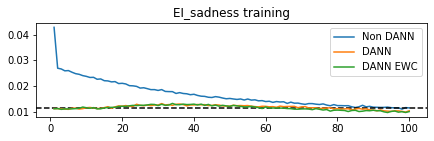

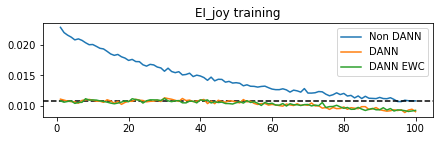

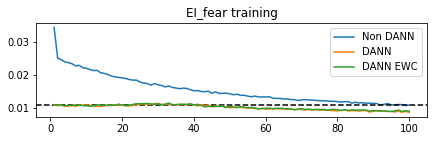

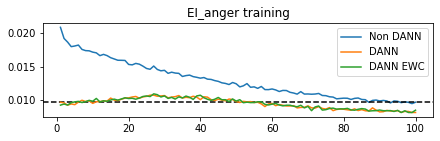

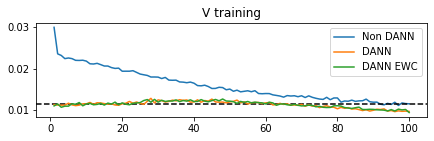

In [56]:
# dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }
# dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }
# dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
  list2_to_plot = dict_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  list3_to_plot = dict_dann_ewc_losses_list [name]['train_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.legend()
  plt.title(name + " training")
  plt.show()



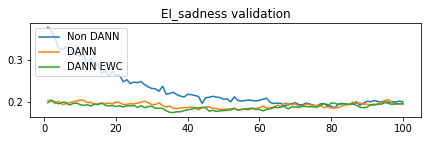

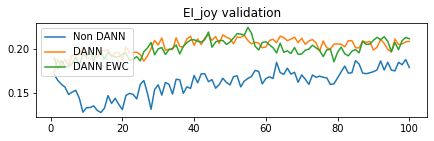

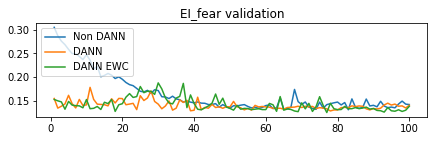

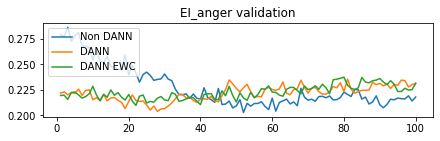

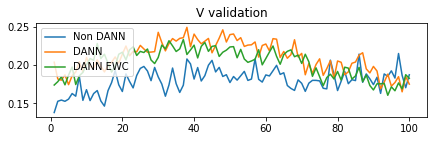

In [57]:
for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  list2_to_plot = dict_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  list3_to_plot = dict_dann_ewc_losses_list [name]['val_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.legend(loc = 'upper left')
  plt.title(name +" validation")

  plt.show()


# Equality Evaluation using Equity Evaluation Corpus

## Loading Evaluation Data
format `[ID	Sentence	Template	Person	Gender	Race Emotion	Emotion word]`

In [58]:
data_EEC = TASK1.EEC['eec']
df_EEC = pd.read_csv(data_EEC)
df_EEC.head()

ID                 Sentence  \
0  2018-En-mystery-05498      Alonzo feels angry.   
1  2018-En-mystery-11722    Alonzo feels furious.   
2  2018-En-mystery-11364  Alonzo feels irritated.   
3  2018-En-mystery-14320    Alonzo feels enraged.   
4  2018-En-mystery-14114    Alonzo feels annoyed.   

                                 Template  Person Gender              Race  \
0  <person subject> feels <emotion word>.  Alonzo   male  African-American   
1  <person subject> feels <emotion word>.  Alonzo   male  African-American   
2  <person subject> feels <emotion word>.  Alonzo   male  African-American   
3  <person subject> feels <emotion word>.  Alonzo   male  African-American   
4  <person subject> feels <emotion word>.  Alonzo   male  African-American   

  Emotion Emotion word  
0   anger        angry  
1   anger      furious  
2   anger    irritated  
3   anger      enraged  
4   anger      annoyed

## Creating evalution function (includes pre-processing)

In [59]:
## padding function : adds padding / truncates to max size
def pad_or_truncate(some_list, target_len = MAX_SIZE, pad_idx = PAD_IDX):
    return some_list[:target_len] + [pad_idx]*(target_len - len(some_list))

## preprocessing function, takes in a tweet and returns padded indexed tweet (input for model)
# def text_pipeline(tweet):
#     indexed_tweet = [field_tweet.vocab.__getitem__(token) for token in preprocess_tweet(tweet)]
#     # print(indexed_tweet)
#     return pad_or_truncate(indexed_tweet, MAX_SIZE , pad_idx = PAD_IDX)
#     # print(indexed_tweet_padded)

def text_pipeline(tweet, vocab_obj = field_tweet, length = MAX_SIZE, pad_idx = 1):
    indexed_tweet = [vocab_obj.vocab.__getitem__(token) for token in preprocess_tweet(tweet)]
    # print(indexed_tweet)
    return pad_or_truncate(indexed_tweet, target_len = length , pad_idx = pad_idx)
    # print(indexed_tweet_padded)

In [60]:
# i = random.randint(0,len(df_EEC))
# tweet_example = df_EEC['Sentence'][i]
# print(tweet_example, text_pipeline(tweet_example))

## Loading model

In [61]:
dict_non_dann_model_saved ={}
dict_dann_model_saved ={}
dict_dann_ewc_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  dict_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_dann_"+EMBEDDING_TO_BE_USED+".pt"  
  dict_dann_ewc_model_saved[name] = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  print(name)
print(dict_non_dann_model_saved)
print(dict_dann_model_saved)

EI_sadness
EI_joy
EI_fear
EI_anger
V
{'EI_sadness': 'EI_sadness_05_01_non_dann_glove_gn.pt', 'EI_joy': 'EI_joy_05_01_non_dann_glove_gn.pt', 'EI_fear': 'EI_fear_05_01_non_dann_glove_gn.pt', 'EI_anger': 'EI_anger_05_01_non_dann_glove_gn.pt', 'V': 'V_05_01_non_dann_glove_gn.pt'}
{'EI_sadness': 'EI_sadness_05_01_dann_glove_gn.pt', 'EI_joy': 'EI_joy_05_01_dann_glove_gn.pt', 'EI_fear': 'EI_fear_05_01_dann_glove_gn.pt', 'EI_anger': 'EI_anger_05_01_dann_glove_gn.pt', 'V': 'V_05_01_dann_glove_gn.pt'}


In [62]:
### Loading Model


# dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}
# dict_dann_model_saved[name] = model_name
# dict_non_dann_model_saved[name]= model_name

dict_loaded_models = {}
for name in list_name:
  non_dann_model_name = dict_non_dann_model_saved[name]
  dann_model_name = dict_dann_model_saved[name]
  dann_ewc_model_name = dict_dann_ewc_model_saved[name]
  # print(non_dann_model_name,dann_model_name)
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_non_dann.eval()

  loaded_model_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann.eval()

  loaded_model_dann_ewc = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann_ewc.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_ewc_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann_ewc.eval()

  dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann,"dann_ewc": loaded_model_dann_ewc}

print(dict_loaded_models)

EI_sadness 4859
EI_joy 4653
EI_fear 5544
EI_anger 4689
V 4320
{'EI_sadness': {'non_dann': CNN1d(
  (embedding): Embedding(4859, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (regression): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
  (domain_classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=2, bias=True)
    (6): LogSoftmax(dim=

In [63]:
### Loading Model (single dataset)

# dict_model_name = {'non_dann':'Non_DANN.pt','dann':'epoch_99.pt'}
# dict_loaded_model ={}
# for model_type, model_name in dict_model_name.items():
#   loaded_model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
#   loaded_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, model_name),map_location=torch.device(DEVICE)))
#   loaded_model.eval()
#   dict_loaded_model[model_type] = loaded_model
# print(dict_loaded_model)

In [64]:
from torch.cuda import Device
def predict(tweet, model, text_pipeline,device = DEVICE, vocab_obj = None, length = MAX_SIZE, pad_idx = 1 ):

  with torch.no_grad():
    # tweet_tensor = torch.tensor(text_pipeline(tweet)).unsqueeze(0).to(device)
    tweet_tensor = torch.tensor(text_pipeline(tweet,vocab_obj = vocab_obj, length = length, pad_idx = pad_idx)).unsqueeze(0).to(device)
    output = model(tweet_tensor)
    return output[0].item()

In [65]:
# i = random.randint(0,len(df_EEC))
# tweet_example = df_EEC['Sentence'][i]
# loaded_model_device = 'cpu'
# loaded_model = dict_loaded_models['EI_anger']['dann'].to(loaded_model_device)
# print(predict(tweet_example, loaded_model,text_pipeline, device= loaded_model_device))

## Creating Sentence pairs (as per SEMVAL18 paper)

In [66]:
dict_f_m_noun_phrase = {'she':'he', 
            'her':'him',
            'this woman':'this man',
            'this girl':'this boy',
            'my sister' : 'my brother',
            'my daughter' : 'my son',
            'my wife': 'my husband',
            'my girlfriend':'my boyfriend',
            'my mother':'my father',
            'my aunt':'my uncle',
            'my mom': 'my dad'
            }

name_male = ['Alonzo','Jamel','Alphonse','Jerome','Leroy','Torrance','Darnell','Lamar','Malik','Terrence','Adam','Harry','Josh','Roger','Alan','Frank','Justin','Ryan','Andrew','Jack'] 
name_female = ['Nichelle','Shereen','Ebony','Latisha','Shaniqua','Jasmine','Tanisha','Tia','Lakisha','Latoya','Amanda','Courtney','Heather','Melanie','Katie','Betsy','Kristin','Nancy','Stephanie','Ellen']


In [67]:
list_unique_template = list(df_EEC['Template'].dropna().unique())
# print(list_unique_template)
list_emotion_word = list(df_EEC['Emotion word'].unique()) # contains nan also
# print(list_emotion_word)
list_gender = list(df_EEC['Gender'].dropna().unique())
# print(list_gender)
list_person = list(df_EEC['Person'].unique())   
# print(list_person)

In [68]:
# list_f_m_noun_phrase =[]
# list_f_m_noun_phrase.extend(name_male)
# list_f_m_noun_phrase.extend(name_female)
# [list_f_m_noun_phrase.extend([f,m]) for f,m in dict_f_m_noun_phrase.items()]
# print(list_f_m_noun_phrase)
# assert set(list_f_m_noun_phrase)<= set(list_person), "The noun phrases are not subset of overall person list"

In [69]:
print(list_emotion_word)
# list_emotion_word= list_emotion_word.append('')
# print(list_emotion_word)

['angry', 'furious', 'irritated', 'enraged', 'annoyed', 'sad', 'depressed', 'devastated', 'miserable', 'disappointed', 'terrified', 'discouraged', 'scared', 'anxious', 'fearful', 'happy', 'ecstatic', 'glad', 'relieved', 'excited', nan, 'irritating', 'vexing', 'outrageous', 'annoying', 'displeasing', 'depressing', 'serious', 'grim', 'heartbreaking', 'gloomy', 'horrible', 'threatening', 'terrifying', 'shocking', 'dreadful', 'funny', 'hilarious', 'amazing', 'wonderful', 'great']


In [70]:
# Template - F - M Noun Phrases chunks (Checked again 3012)

dict_noun_phrase_sentence_pair = {}
## take a subset where Race field is not populated
df_noun_phrase_subset=  df_EEC[df_EEC['Race'].isna()] ## includes values which do not have Race 
count = 0
# print(len(df_noun_phrase_subset),df_noun_phrase_subset.head())
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_noun_phrase_subset['Template']== template)
    condition_2 = (df_noun_phrase_subset['Emotion word'] == emotion_word)
    condition_3 = (df_noun_phrase_subset['Gender'] == 'female')
    condition_4 = (df_noun_phrase_subset['Gender'] == 'male')
    list_female = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_noun_phrase_sentence_pair[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_noun_phrase_subset['Emotion word'].isna())
      list_female_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_noun_phrase_sentence_pair[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1

print(count)
print(len(dict_noun_phrase_sentence_pair),"dict_noun_phrase_sentence_pair............ \n",dict_noun_phrase_sentence_pair)


144
144 dict_noun_phrase_sentence_pair............ 
 {0: (['She feels angry.', 'This woman feels angry.', 'This girl feels angry.', 'My sister feels angry.', 'My daughter feels angry.', 'My wife feels angry.', 'My girlfriend feels angry.', 'My mother feels angry.', 'My aunt feels angry.', 'My mom feels angry.'], ['He feels angry.', 'This man feels angry.', 'This boy feels angry.', 'My brother feels angry.', 'My son feels angry.', 'My husband feels angry.', 'My boyfriend feels angry.', 'My father feels angry.', 'My uncle feels angry.', 'My dad feels angry.']), 1: (['She feels furious.', 'This woman feels furious.', 'This girl feels furious.', 'My sister feels furious.', 'My daughter feels furious.', 'My wife feels furious.', 'My girlfriend feels furious.', 'My mother feels furious.', 'My aunt feels furious.', 'My mom feels furious.'], ['He feels furious.', 'This man feels furious.', 'This boy feels furious.', 'My brother feels furious.', 'My son feels furious.', 'My husband feels furiou

In [71]:
# Template -  ORIGINAL TRYING 3012

dict_original_sentence_pair = {}
count = 0

for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC['Template']== template)
    condition_2 = (df_EEC['Emotion word'].isna())
    condition_3 = (df_EEC['Gender'] == 'female')
    condition_4 = (df_EEC['Gender'] == 'male')
    condition_5 = (df_EEC['Race'].notnull())
    condition_6 = (df_EEC['Race'].isna())
    condition_9 = (df_EEC['Emotion word'].notnull())
    list_noun_phrase_female = []
    list_noun_phrase_male = []
    if pd.isnull(emotion_word):
      
      # Check for named people - no emotion
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1 
      # Check for noun phrases - emotion
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

    else: # emotion is present
      # Check for named people - with emotion
      list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1
      # Check for noun phrases - with emotion
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 
      

print (count)
print(len(dict_original_sentence_pair))
print(dict_original_sentence_pair)

      
print(len(dict_original_sentence_pair),"dict_original_sentence_pair............ \n",dict_original_sentence_pair)

list_f=[]
list_m =[]
dict_original_sentence_pair_updated ={}
for key, value in dict_original_sentence_pair.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]
  # list_f.append(value[0])
  # list_m.append(value[1])

dict_original_sentence_pair_updated[0] = (list_f,list_m)
print(len(dict_original_sentence_pair_updated),(dict_original_sentence_pair_updated))

288
288
{0: (['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'], ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']), 1: (['She feels angry.', 'This woman feels angry.', 'This girl 

In [72]:

# list_f=[]
# list_m =[]
# count = 0
# dict_original_sentence_pair_updated ={}
# for key, value in dict_original_sentence_pair.items():
#   # list_f.append(value[0])
#   # list_m.append(value[1])
#   print(type(value[0]))
#   list_f = list_f + value[0]
#   print(list_f)
#   count += 1
#   if count == 2:
#     break

# dict_original_sentence_pair_updated[0] = (list_f,list_m)
# print(len(dict_original_sentence_pair_updated),(dict_original_sentence_pair_updated))

In [73]:
# # Template - F - M Noun Phrases chunks ORIGINAL (Checked on 3012, found incorrect - does not take into account where Race is present)
# dict_original_sentence_pair = {}
# count = 0

# for template in list_unique_template:
#   for f, m in dict_f_m_noun_phrase.items():
#     condition_1 = df_EEC['Template']== template
#     condition_2 = df_EEC['Person']== f
#     condition_3 = df_EEC['Person']== m
#     df_temp_f = df_EEC[(condition_1 & condition_2 )] 
#     df_temp_m = df_EEC[(condition_1 & condition_3 )]
#     for emotion_word in list_emotion_word:
      
#       condition_4 = df_EEC['Emotion word'] == emotion_word
#       k = df_temp_f[condition_4]['Sentence']
#       v = df_temp_m[condition_4]['Sentence']
#       assert len(k)==len(v), "Problem is in Noun Phase Chunks where emotion_word is not null"
#       if len(k) > 0 and len (v) > 0:
#         dict_original_sentence_pair[count] = (k.values[0],v.values[0])
#         count = count + 1
      
#       ## Checking for column values where emotion word value blank
#       if pd.isnull(emotion_word):
#         k_null = df_temp_f[df_temp_f['Emotion word'].isna()]['Sentence']
#         v_null = df_temp_m[df_temp_m['Emotion word'].isna()]['Sentence']
#         assert len(k_null)==len(v_null), "Problem is in Noun Phase Chunks where emotion_word is  null"
#         if len(k_null) > 0 and len (v_null) > 0:
#           dict_original_sentence_pair[count] = (k_null.values[0],v_null.values[0])
#           count = count + 1
      
# print(len(dict_original_sentence_pair),"dict_original_sentence_pair............ \n",dict_original_sentence_pair)

# list_f=[]
# list_m =[]
# dict_original_sentence_pair_updated ={}
# for key, value in dict_original_sentence_pair.items():
#   list_f.append(value[0])
#   list_m.append(value[1])

# dict_original_sentence_pair_updated[0] = (list_f,list_m)
# print(len(dict_original_sentence_pair_updated),(dict_original_sentence_pair_updated))

In [74]:
# for Named people (Checked again 3012)

dict_list_named_sentence_pairs ={}
df_EEC_subset = df_EEC.dropna(subset = ['Race']) ## removes values which do not have Race 
print(len(df_EEC_subset))

count = 0
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC_subset['Template']== template)
    condition_2 = (df_EEC_subset['Emotion word'] == emotion_word)
    condition_3 = (df_EEC_subset['Gender'] == 'female')
    condition_4 = (df_EEC_subset['Gender'] == 'male')
    list_female = df_EEC_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_EEC_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    # print(len(list_female), len(list_male))
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_list_named_sentence_pairs[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_EEC_subset['Emotion word'].isna())
      list_female_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_list_named_sentence_pairs[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1
        
print (count)
print(len(dict_list_named_sentence_pairs))
print(dict_list_named_sentence_pairs)

5760
144
144
{0: (['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'], ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']), 1: (['Nichelle feels furious.', 'Shereen feels furious.', 

In [75]:
# for no emotion people (Checked again 3012)

dict_no_emotion_sentence_pairs ={}
count = 0


for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    if pd.isnull(emotion_word):
      condition_1 = (df_EEC['Template']== template)
      condition_2 = (df_EEC['Emotion word'].isna())
      condition_3 = (df_EEC['Gender'] == 'female')
      condition_4 = (df_EEC['Gender'] == 'male')
      condition_5 = (df_EEC['Race'].notnull())
      condition_6 = (df_EEC['Race'].isna())

      # Check for named people
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_female,list_male)
        count = count + 1 

      # Check for noun phrases
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

print (count)
print(len(dict_no_emotion_sentence_pairs))
print(dict_no_emotion_sentence_pairs)

8
8
{0: (['I saw Nichelle in the market.', 'I saw Shereen in the market.', 'I saw Ebony in the market.', 'I saw Latisha in the market.', 'I saw Shaniqua in the market.', 'I saw Jasmine in the market.', 'I saw Tanisha in the market.', 'I saw Tia in the market.', 'I saw Lakisha in the market.', 'I saw Latoya in the market.', 'I saw Amanda in the market.', 'I saw Courtney in the market.', 'I saw Heather in the market.', 'I saw Melanie in the market.', 'I saw Katie in the market.', 'I saw Betsy in the market.', 'I saw Kristin in the market.', 'I saw Nancy in the market.', 'I saw Stephanie in the market.', 'I saw Ellen in the market.'], ['I saw Alonzo in the market.', 'I saw Jamel in the market.', 'I saw Alphonse in the market.', 'I saw Jerome in the market.', 'I saw Leroy in the market.', 'I saw Torrance in the market.', 'I saw Darnell in the market.', 'I saw Lamar in the market.', 'I saw Malik in the market.', 'I saw Terrence in the market.', 'I saw Adam in the market.', 'I saw Harry in t

In [76]:
print(dict_list_named_sentence_pairs[0][0],"\n",dict_list_named_sentence_pairs[0][1])

['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'] 
 ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']


## Two Sample t- test

In [77]:
# f ='She feels angry.'
# m ='He feels angry.'
# f_indices = text_pipeline(f)
# m_indices = text_pipeline(m)
# f_value = predict(f, loaded_model,text_pipeline,device= loaded_model_device)
# m_value = predict(m, loaded_model,text_pipeline,device= loaded_model_device)
# print(f_value,m_value)
# stats.ttest_rel(f_value, m_value)

In [78]:
# Function for t-test processing

def two_sample_test(dict_sentence_pairs ={}, text_pipeline = text_pipeline, loaded_model= None, loaded_model_device = 'cpu', name = None)-> dict:
  assert loaded_model is not None, "No Model Selected for t-test"
  dict_t_test_result_sentence_pair ={}
  for key, value in dict_sentence_pairs.items():

    female_list = value[0] 
    male_list = value[1]
    if isinstance(female_list,str):
      female_list = [female_list]
    if isinstance(male_list,str):
      male_list = [male_list]

    assert len(female_list) == len(male_list), f"Different lengths: Lengths of female list is {len(female_list)} and male list is {len(male_list)}"
    
    # INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
    PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]


    female_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in female_list]
    male_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in male_list]

    # female_list_indices = [text_pipeline(tweet_example) for tweet_example in female_list]
    # male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

    female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX ) for sentence in female_list]
    male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for sentence in male_list]
    # female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
    # male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]

    t_test_result = stats.ttest_rel(female_list_output, male_list_output)
    dict_t_test_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
  # print(dict_t_test_result_sentence_pair)
  return dict_t_test_result_sentence_pair



In [79]:
#  dict_loaded_models

In [80]:
dict_loaded_models.keys()

dict_keys(['EI_sadness', 'EI_joy', 'EI_fear', 'EI_anger', 'V'])

In [81]:
# dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann}

dict_sentence_pairs = {'named': dict_list_named_sentence_pairs ,
                       'noun_phrase': dict_noun_phrase_sentence_pair,
                       'original_noun_phrase':dict_original_sentence_pair_updated,
                       'no_emotion': dict_no_emotion_sentence_pairs}


dict_t_test = {}
for name, model_dict in dict_loaded_models.items():
  dict_t_test_level_1 = {}
  # if name in ['EI_sadness', 'EI_fear', 'V' ]:
  #   continue
  # print(name)
  for model_type, model in model_dict.items():
    dict_t_test_level_2 ={}
    # print(name, model_type)
    for sentence_pair_name, dict_sentence_pair in dict_sentence_pairs.items():
      # key_name = str(name+ "_" + model_type + "_" + sentence_pair_name)
      # print(key_name)
      print(name, model_type,sentence_pair_name)
      loaded_model = dict_loaded_models[name][model_type]
      # dict_t_test[key_name] = two_sample_test(dict_sentence_pairs = dict_sentence_pair ,
      #                                         text_pipeline = text_pipeline, 
      #                                         loaded_model = loaded_model, 
      #                                         loaded_model_device = 'cpu')
      dict_t_test_level_2[sentence_pair_name] = two_sample_test(dict_sentence_pairs = dict_sentence_pair ,
                                        text_pipeline = text_pipeline, 
                                        loaded_model = loaded_model, 
                                        loaded_model_device = 'cpu',
                                        name = name)
      print(sentence_pair_name, dict_t_test_level_2[sentence_pair_name] )
    dict_t_test_level_1[model_type] = dict_t_test_level_2
    print(model_type,sentence_pair_name, dict_t_test_level_1[model_type])
  dict_t_test[name] = dict_t_test_level_1
  print(name, model_type,sentence_pair_name, dict_t_test[name])
  
print(dict_t_test)
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


EI_sadness non_dann named
named {0: (-1.3030927725517232, 0.20811477632164624, -0.004679034650325778), 1: (-0.7189698935511729, 0.4809092377856624, -0.0030072242021560724), 2: (-1.5073496901612617, 0.14816839191956305, -0.0075326114892959595), 3: (-1.5073496901612617, 0.14816839191956305, -0.0075326114892959595), 4: (-0.35244467021867376, 0.728384168020173, -0.001306648552417744), 5: (-0.5058408766032084, 0.6187867813191169, -0.001874116063117992), 6: (-1.0726403194863288, 0.2968680999825172, -0.0047556221485137995), 7: (-1.3724947005206267, 0.18589548598111785, -0.005169788002967829), 8: (-1.5073496901612617, 0.14816839191956305, -0.0075326114892959595), 9: (-1.8705836101618791, 0.07688795353808092, -0.006795556843280794), 10: (-0.8764282749891406, 0.3917437348421291, -0.0044281683862209265), 11: (-1.0053477851487183, 0.32736216164446186, -0.004738457500934601), 12: (-1.2688401917022558, 0.21982304146990297, -0.004785034060478213), 13: (-1.5073496901612617, 0.14816839191956305, -0.007

In [82]:
# list_sentence_pairs = ['named','noun_phrase']
# dict_t_test ={}
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


In [83]:
# dict_t_test.items()

In [84]:
# dict_t_test_noun_phrase_sentence_pair = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
# dict_t_test_named_sentence_pairs = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')

In [85]:
# dict_result_named_sentence_pair ={}

# for key, value in dict_list_named_sentence_pairs.items():
#   female_list = value[0]
#   male_list = value[1]
#   female_list_indices = [ text_pipeline(tweet_example)for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_named_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print((dict_result_named_sentence_pair))

In [86]:
# #without named people
# dict_result_sentence_pair ={}
# # for key, value in dict_sentence_pair:
# #   if len(value[0])
# print(len(dict_sentence_pair))

# for key, value in dict_sentence_pair.items():
#   female_list = [value[0]]
#   male_list = [value[1]]
#   # if len(female_list)!=len(male_list):
#   #   print("key:", key)
#   #   print(female_list,"\n",male_list)
#   #   print(len(female_list),"-",len(male_list))
#   #   print(text_pipeline(female_list[0]),"\n",text_pipeline(male_list[0]))
#   #   break

#   female_list_indices = [ text_pipeline(tweet_example) for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example) for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print(dict_result_sentence_pair)

# Analysis of results (based on semval paper)

In [87]:
# dict_t_test_noun_phrase_sentence_pair
# dict_t_test_named_sentence_pairs

In [88]:
# len(dict_t_test_noun_phrase_sentence_pair),len(dict_t_test_named_sentence_pairs)

In [89]:
def analysis_t_test(dict_t_test_sentence_pairs, threshold = 0.05):
  list_output =[]
  for key, test_output in dict_t_test_sentence_pairs.items():
    significant=True
    t_statistic = test_output[0]
    p_value = test_output[1]
    f_m_diff = test_output[2]
    if (float(p_value) > float(threshold) or float(p_value) == float(threshold)):
      significant=False
      category = 'f_equals_m'
    else:
      significant=True
      
      if f_m_diff > 0:
        category='f_high_m_low'
      else:
        category = 'f_low_m_high' 
    list_output.append([key,t_statistic,p_value,significant,f_m_diff,category])
    
  df_columns = ['key','t_statistic','p_value', 'significant','delta','category']
  df_output = pd.DataFrame(list_output, columns = df_columns)

  list_category = list(df_output['category'].unique())
  list_statistics =[]
  for category in list_category:
    df_temp = df_output[df_output['category']==category]
    average = df_temp['delta'].mean()
    # print(category,len(df_temp), average)
    list_statistics.append([category,len(df_temp), average])
  df_statistics = pd.DataFrame(list_statistics, columns = ['category', 'num_pairs','average_difference'])
  return df_statistics


# print(analysis_t_test(dict_t_test_noun_phrase_sentence_pair))
# print(analysis_t_test(dict_t_test_named_sentence_pairs))


In [90]:
{'EI_anger': {
    'non_dann': {
        'original_noun_phrase': {
            0: (0.1998956871564016, 0.8415904073105785, 3.9207107490946136e-05)}}, 
    'dann': {
        'original_noun_phrase': {
            0: (-3.055498578204014, 0.002288182511007486, -0.0005662351846695279)}}}, 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513, 0.4856923878774828, 0.0001477275302426695)}}, 'dann': {'original_noun_phrase': {0: (2.6524225900747918, 0.008079505029578445, 0.0012747823571165329)}}}, 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802, 0.057935765936073504, -0.0004837316667868352)}}, 'dann': {'original_noun_phrase': {0: (-4.093950892599476, 4.476596480751689e-05, -0.0010545446744395504)}}}, 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935, 0.210942010423521, -0.0002394391637708937)}}, 'dann': {'original_noun_phrase': {0: (-6.649931016376002, 4.1525086430524637e-11, -0.0012206101997030983)}}}, 'V': {'non_dann': {'original_noun_phrase': {0: (-0.6159244491387837, 0.5380417924786083, -0.00019533265795973476)}}, 'dann': {'original_noun_phrase': {0: (-1.5534286604033418, 0.12054065128353071, -0.0005289117702179658)}}}}


{'EI_anger': {'non_dann': {'original_noun_phrase': {0: (0.1998956871564016,
     0.8415904073105785,
     3.9207107490946136e-05)}},
  'dann': {'original_noun_phrase': {0: (-3.055498578204014,
     0.002288182511007486,
     -0.0005662351846695279)}}},
 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513,
     0.4856923878774828,
     0.0001477275302426695)}},
  'dann': {'original_noun_phrase': {0: (2.6524225900747918,
     0.008079505029578445,
     0.0012747823571165329)}}},
 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802,
     0.057935765936073504,
     -0.0004837316667868352)}},
  'dann': {'original_noun_phrase': {0: (-4.093950892599476,
     4.476596480751689e-05,
     -0.0010545446744395504)}}},
 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935,
     0.210942010423521,
     -0.0002394391637708937)}},
  'dann': {'original_noun_phrase': {0: (-6.649931016376002,
     4.1525086430524637e-11,
     -0.001220610199

In [91]:
dict_statistics={}
for name, dict_model_type_sentence_pair in dict_t_test.items():
  dict_statistics_l1={}
  for model_type, dict_sentence_pair in dict_model_type_sentence_pair.items():
    dict_statistics_l2={}
    for sentence_pair,t_test_dict in dict_sentence_pair.items():
      df_statistics = analysis_t_test(t_test_dict, threshold = 0.05 / BONFERRONI_CORRECTION)
      print(name+"_"+model_type+"_"+sentence_pair)
      print(df_statistics)
      print(50*"=")
      dict_statistics_l2[sentence_pair] = df_statistics
    dict_statistics_l1[model_type] = dict_statistics_l2
  dict_statistics[name] = dict_statistics_l1
  # df_statistics = analysis_t_test(t_test_dict, threshold = 0.05)
  # dict_statistics[model_type_sentence_pair_name] = df_statistics

EI_sadness_non_dann_named
     category  num_pairs  average_difference
0  f_equals_m        144           -0.004317
EI_sadness_non_dann_noun_phrase
     category  num_pairs  average_difference
0  f_equals_m        144           -0.013913
EI_sadness_non_dann_original_noun_phrase
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.007515
EI_sadness_non_dann_no_emotion
     category  num_pairs  average_difference
0  f_equals_m          8             -0.0094
EI_sadness_dann_named
     category  num_pairs  average_difference
0  f_equals_m        144            0.001249
EI_sadness_dann_noun_phrase
     category  num_pairs  average_difference
0  f_equals_m        144           -0.011313
EI_sadness_dann_original_noun_phrase
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002939
EI_sadness_dann_no_emotion
     category  num_pairs  average_difference
0  f_equals_m          8           -0.004551
EI_sadness_dann_ewc_named
  

In [92]:
print(dict_statistics)

{'EI_sadness': {'non_dann': {'named':      category  num_pairs  average_difference
0  f_equals_m        144           -0.004317, 'noun_phrase':      category  num_pairs  average_difference
0  f_equals_m        144           -0.013913, 'original_noun_phrase':        category  num_pairs  average_difference
0  f_low_m_high          1           -0.007515, 'no_emotion':      category  num_pairs  average_difference
0  f_equals_m          8             -0.0094}, 'dann': {'named':      category  num_pairs  average_difference
0  f_equals_m        144            0.001249, 'noun_phrase':      category  num_pairs  average_difference
0  f_equals_m        144           -0.011313, 'original_noun_phrase':        category  num_pairs  average_difference
0  f_low_m_high          1           -0.002939, 'no_emotion':      category  num_pairs  average_difference
0  f_equals_m          8           -0.004551}, 'dann_ewc': {'named':      category  num_pairs  average_difference
0  f_equals_m        144         

In [93]:
# dict_statistics={}
# for model_type_sentence_pair_name, t_test_dict in dict_t_test.items():
#   df_statistics = analysis_t_test(t_test_dict, threshold = 0.05)
#   dict_statistics[model_type_sentence_pair_name] = df_statistics


In [94]:
# for model_type_sentence_pair_name, df_statistics in dict_statistics.items():
#   print(model_type_sentence_pair_name,"\n",df_statistics)
#   print(50*"=")